# MultiAttention

## EfficientNet

In [15]:
# Versi
__version__ = "0.6.3"

# Import Pustaka Standar dan PyTorch
import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo
# import kornia # Tidak digunakan dalam kode yang diberikan, bisa di-uncomment jika diperlukan

########################################################################
############### BAGIAN DARI utils.py ###################################
########################################################################

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.),###modify 0.4 -> original code had 0.4, then user text changed to 0. Keeping it 0. as per text.
        'efficientnet-b5': (1.6, 2.2, 456, 0.),###modify 0.4 -> original code had 0.4, then user text changed to 0. Keeping it 0. as per text.
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            # stride dalam BlockArgs adalah list, misal [s], jadi ambil elemen pertama
            's%d%d' % (block.stride[0], block.stride[0]), # Diperbaiki: stride field name di BlockArgs
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if hasattr(block, 'se_ratio') and block.se_ratio is not None and 0 < block.se_ratio <= 1: # Diperbaiki: check se_ratio
            args.append('se%s' % block.se_ratio)
        if hasattr(block, 'id_skip') and block.id_skip is False: # Diperbaiki: check id_skip
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args_str = [ # Renamed from blocks_args to avoid conflict later if any
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args_str) # Use the renamed string list

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}


url_map_advprop = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',
}


def load_pretrained_weights(model, model_name, load_fc=True, advprop=False):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    url_map_ = url_map_advprop if advprop else url_map
    state_dict = model_zoo.load_url(url_map_[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        # Original code used print(res.missing_keys), which is not standard attribute
        # It should be res.missing_keys (a list) or res itself if load_state_dict returns an object
        # Assuming res is the result of load_state_dict which is a namedtuple with missing_keys and unexpected_keys
        if hasattr(res, 'missing_keys') and res.missing_keys:
             print(f"Missing keys: {res.missing_keys}")
        # assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        # More robust check:
        expected_missing = {'_fc.weight', '_fc.bias'}
        actual_missing = set(res.missing_keys) if hasattr(res, 'missing_keys') else set()
        
        if not actual_missing.issubset(expected_missing) or not expected_missing.issubset(actual_missing):
             print(f"Warning: Issue loading pretrained weights. Expected missing: {expected_missing}, Actual missing: {actual_missing}")

    print('Loaded pretrained weights for {}'.format(model_name))

########################################################################
############### BAGIAN DARI model.py ###################################
########################################################################

class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        inp = self._block_args.input_filters
        oup = self._block_args.input_filters * self._block_args.expand_ratio
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters: # Stride is a list
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs
        return x

    def set_swish(self, memory_efficient=True):
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model.
    """
    def __init__(self, blocks_args=None, global_params=None, escape=''):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self.escape = escape
        self._global_params = global_params
        self._blocks_args = blocks_args
        
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        in_channels = 3
        out_channels = round_filters(32, self._global_params)
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        self._blocks = nn.ModuleList([])
        self.stage_map = []
        stage_count = 0
        for block_args_item in self._blocks_args: # renamed to avoid conflict
            block_args_item = block_args_item._replace(
                input_filters=round_filters(block_args_item.input_filters, self._global_params),
                output_filters=round_filters(block_args_item.output_filters, self._global_params),
                num_repeat=round_repeats(block_args_item.num_repeat, self._global_params)
            )
            stage_count += 1
            self.stage_map += [''] * (block_args_item.num_repeat - 1)
            self.stage_map.append('b%s' % stage_count)
            
            self._blocks.append(MBConvBlock(block_args_item, self._global_params))
            
            if block_args_item.num_repeat > 1:
                block_args_item = block_args_item._replace(input_filters=block_args_item.output_filters, stride=[1]) # Stride is a list
            for _ in range(block_args_item.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args_item, self._global_params))

        # Head (menggunakan block_args_item terakhir yang telah diupdate)
        in_channels_head = block_args_item.output_filters # Diambil dari block_args terakhir yang sudah diproses
        out_channels_head = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels_head, out_channels_head, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels_head, momentum=bn_mom, eps=bn_eps)

        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels_head, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_features(self, inputs, layers):
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        layers['b0'] = x
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            stage = self.stage_map[idx]
            if stage:     
                layers[stage] = x
                if stage == self.escape:
                    return None
        x = self._bn1(self._conv_head(x)) # Conv_head dipindahkan ke sini
        x = self._swish(x) # Swish setelah conv_head
        return x

    def forward(self, x):
        bs = x.size(0)
        layers = {}
        x = self.extract_features(x, layers)
        if x is None: # Early escape
            return layers 
        
        layers['final_conv'] = x # Renamed from 'final' to be more descriptive
        
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
        x = self._fc(x)
        layers['logits'] = x
        return layers

    @classmethod
    def from_name(cls, model_name, override_params=None, escape=''):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params, escape)

    @classmethod
    def from_pretrained(cls, model_name, advprop=False, num_classes=1000, in_channels=3, escape=''):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes}, escape=escape)
        try:
            load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000), advprop=advprop)
        except Exception as e:
            print(f"Could not load pretrained weights for {model_name}: {e}. Model will be initialized randomly.")

        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        valid_models = ['efficientnet-b'+str(i) for i in range(9)] + ['efficientnet-l2'] # Added l2
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

# Perbaikan kecil pada BlockDecoder._encode_block_string
# Atribut stride pada BlockArgs adalah list, bukan tuple.
# TensorFlow strides[0], strides[1] vs PyTorch stride[0]
# Dan juga, memastikan 'se_ratio' dan 'id_skip' ada sebelum diakses.

def _encode_block_string_fixed(block):
    """Encodes a block to a string. (Fixed version)"""
    args = [
        'r%d' % block.num_repeat,
        'k%d' % block.kernel_size,
        # block.stride adalah list [s], jadi kita gunakan block.stride[0] untuk kedua dimensi
        's%d%d' % (block.stride[0], block.stride[0]),
        'e%s' % block.expand_ratio,
        'i%d' % block.input_filters,
        'o%d' % block.output_filters
    ]
    if hasattr(block, 'se_ratio') and block.se_ratio is not None and 0 < block.se_ratio <= 1:
        args.append('se%s' % block.se_ratio)
    if hasattr(block, 'id_skip') and block.id_skip is False:
        args.append('noskip')
    return '_'.join(args)

BlockDecoder._encode_block_string = _encode_block_string_fixed


########################################################################
############### CONTOH PENGGUNAAN ######################################
########################################################################

if __name__ == '__main__': # Hanya jalan jika dieksekusi sebagai script, bukan saat diimport
                           # Dalam notebook, ini akan selalu jalan jika sel dieksekusi
    print(f"EfficientNet PyTorch Version: {__version__}")

    # Coba membuat model dari nama
    print("\n--- Testing Model Creation from_name ---")
    try:
        model_b0_custom = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes': 10})
        print("Successfully created 'efficientnet-b0' with 10 classes (random weights).")
        # print(model_b0_custom) # Uncomment untuk melihat struktur model
    except Exception as e:
        print(f"Error creating model_b0_custom: {e}")

    # Coba memuat model pre-trained (membutuhkan koneksi internet untuk pertama kali)
    print("\n--- Testing Model Creation from_pretrained (will download weights) ---")
    try:
        model_b0_pretrained = EfficientNet.from_pretrained('efficientnet-b0')
        print("Successfully loaded 'efficientnet-b0' with pretrained weights (1000 classes).")
        
        # Uji forward pass dengan dummy input
        img_size_b0 = EfficientNet.get_image_size('efficientnet-b0')
        dummy_input = torch.randn(2, 3, img_size_b0, img_size_b0) # Batch size 2
        
        model_b0_pretrained.eval() # Set ke mode evaluasi
        with torch.no_grad(): # Tidak perlu gradien untuk inferensi
             outputs = model_b0_pretrained(dummy_input)
        
        print(f"Output logits shape for b0: {outputs['logits'].shape}") # Harusnya [2, 1000]
        
        # Test feature extraction with escape
        print("\n--- Testing Feature Extraction with escape ---")
        model_b0_escape = EfficientNet.from_pretrained('efficientnet-b0', escape='b3')
        model_b0_escape.eval()
        with torch.no_grad():
            features = model_b0_escape(dummy_input)
        print(f"Features extracted up to b3 (b3 should be in keys): {features.keys()}")
        if 'b3' in features:
            print(f"Shape of 'b3' features: {features['b3'].shape}")
        if 'logits' in features:
            print("Logits should not be present due to escape.")
        else:
            print("Logits correctly not present due to escape.")


    except Exception as e:
        print(f"Error loading or testing pretrained efficientnet-b0: {e}")
        print("This might be due to network issues or if the weights URL is inaccessible.")

    print("\n--- Testing a different model (e.g., b1) ---")
    try:
        model_b1_pretrained = EfficientNet.from_pretrained('efficientnet-b1', num_classes=50, advprop=True) # advprop weights
        print("Successfully loaded 'efficientnet-b1' (advprop) with 50 classes (FC re-initialized).")
        img_size_b1 = EfficientNet.get_image_size('efficientnet-b1')
        dummy_input_b1 = torch.randn(1, 3, img_size_b1, img_size_b1)
        model_b1_pretrained.eval()
        with torch.no_grad():
            outputs_b1 = model_b1_pretrained(dummy_input_b1)
        print(f"Output logits shape for b1: {outputs_b1['logits'].shape}") # Harusnya [1, 50]

    except Exception as e:
        print(f"Error loading or testing pretrained efficientnet-b1: {e}")

EfficientNet PyTorch Version: 0.6.3

--- Testing Model Creation from_name ---
Successfully created 'efficientnet-b0' with 10 classes (random weights).

--- Testing Model Creation from_pretrained (will download weights) ---
Loaded pretrained weights for efficientnet-b0
Successfully loaded 'efficientnet-b0' with pretrained weights (1000 classes).
Output logits shape for b0: torch.Size([2, 1000])

--- Testing Feature Extraction with escape ---
Loaded pretrained weights for efficientnet-b0
Features extracted up to b3 (b3 should be in keys): dict_keys(['b0', 'b1', 'b2', 'b3'])
Shape of 'b3' features: torch.Size([2, 40, 28, 28])
Logits correctly not present due to escape.

--- Testing a different model (e.g., b1) ---
Missing keys: ['_fc.weight', '_fc.bias']
Loaded pretrained weights for efficientnet-b1
Successfully loaded 'efficientnet-b1' (advprop) with 50 classes (FC re-initialized).
Output logits shape for b1: torch.Size([1, 50])


## Xception

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init # init tidak secara eksplisit digunakan setelah ini, tapi mungkin untuk referensi

# Kelas Helper
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[] # list untuk layer-layer dalam blok

        filters=in_filters
        if grow_first: # Menentukan apakah filter output dicapai pada SeparableConv pertama atau terakhir
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters # Filter untuk SeparableConv berikutnya adalah out_filters

        for i in range(reps-1): # Loop untuk sisa repetisi SeparableConv
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first: # Jika filter output dicapai pada SeparableConv terakhir
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu: # Jika blok tidak dimulai dengan ReLU
            if rep: # Pastikan rep tidak kosong sebelum slicing
                rep = rep[1:]
        else: # Jika blok dimulai dengan ReLU
            if rep: # Pastikan rep tidak kosong sebelum mengubah elemen
                rep[0] = nn.ReLU(inplace=False) # ReLU pertama tidak inplace

        if strides != 1: # Jika ada downsampling dengan stride
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x = x + skip # Tambahkan skip connection
        return x

# Definisi Model Xception
class xception_model(nn.Module): # Mengganti nama kelas agar tidak bentrok jika ada fungsi 'xception'
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self,num_classes=1000, pretrained='imagenet', escape=''): # default num_classes 1000 untuk imagenet
        super(xception_model, self).__init__()
        self.escape=escape
        self.num_classes = num_classes

        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=0, bias=False) # Sesuai Cadene: padding 0
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3, stride=1, padding=0, bias=False) # Sesuai Cadene: padding 0, stride 1 (implisit)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True) # ReLU setelah conv2+bn2

        self.block1=Block(64,128, reps=2, strides=2, start_with_relu=False, grow_first=True)
        self.block2=Block(128,256, reps=2, strides=2, start_with_relu=True, grow_first=True)
        self.block3=Block(256,728, reps=2, strides=2, start_with_relu=True, grow_first=True)

        # Middle flow
        self.block4=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block5=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block6=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block7=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block8=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block9=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block10=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block11=Block(728,728, reps=3, strides=1, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block12=Block(728,1024, reps=2, strides=2, start_with_relu=True, grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,stride=1,padding=1) # padding 1 untuk 'same'
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = SeparableConv2d(1536,2048,3,stride=1,padding=1) # padding 1 untuk 'same'
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(inplace=True) # ReLU setelah conv4+bn4

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.last_linear = nn.Linear(2048, self.num_classes)

        # Mendefinisikan urutan stage untuk forward pass dan feature extraction
        self.seq=[]
        # Stage 'b0_conv1': output setelah conv1, bn1, relu1
        self.seq.append(('b0_conv1', [self.conv1, self.bn1, self.relu1]))
        # Stage 'b0_conv2': output setelah conv2, bn2 (sebelum relu2 berikutnya)
        self.seq.append(('b0_conv2', [self.conv2, self.bn2]))
        # Stage 'b1': output setelah relu2, block1
        self.seq.append(('b1', [self.relu2, self.block1]))
        self.seq.append(('b2', [self.block2]))
        self.seq.append(('b3', [self.block3]))
        self.seq.append(('b4', [self.block4]))
        self.seq.append(('b5', [self.block5]))
        self.seq.append(('b6', [self.block6]))
        self.seq.append(('b7', [self.block7]))
        self.seq.append(('b8', [self.block8]))
        self.seq.append(('b9', [self.block9]))
        self.seq.append(('b10', [self.block10]))
        self.seq.append(('b11', [self.block11]))
        self.seq.append(('b12', [self.block12]))
        # Stage 'final_conv3': output setelah conv3, bn3, relu3
        self.seq.append(('final_conv3', [self.conv3, self.bn3, self.relu3]))
        # Stage 'final_conv4': output setelah conv4, bn4 (sebelum relu4 berikutnya)
        self.seq.append(('final_conv4', [self.conv4, self.bn4]))
        # Stage 'logits': output akhir setelah relu4, pooling, dan linear layer
        self.seq.append(('logits', [self.relu4, self.avgpool, lambda x: x.view(x.size(0), -1), self.last_linear]))

        if pretrained=='imagenet':
            try:
                state_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth')
                # Hapus 'last_linear.weight' dan 'last_linear.bias' jika num_classes berbeda
                if self.num_classes != 1000: # Bobot Cadene untuk 1000 kelas
                    for key in ['last_linear.weight', 'last_linear.bias']:
                        if key in state_dict:
                            del state_dict[key]
                self.load_state_dict(state_dict, strict=False)
                print(f"Loaded pretrained ImageNet weights for Xception (num_classes={self.num_classes}).")
                if self.num_classes != 1000:
                    print("Classifier head (last_linear) re-initialized.")
            except Exception as e:
                print(f"Could not load pretrained ImageNet weights: {e}. Model weights are randomly initialized.")
                self._init_weights()

        elif pretrained and isinstance(pretrained, str): # Path ke file bobot
            try:
                ckpt=torch.load(pretrained,map_location='cpu')
                # Asumsi ckpt mungkin memiliki 'state_dict' atau langsung state_dict
                if 'state_dict' in ckpt:
                    state_dict_to_load = ckpt['state_dict']
                else:
                    state_dict_to_load = ckpt

                # Sesuaikan jika num_classes berbeda dari yang ada di checkpoint
                # Ini memerlukan pengetahuan tentang nama layer FC di checkpoint.
                # Untuk saat ini, kita asumsikan nama 'last_linear' sama.
                loaded_fc_size = state_dict_to_load.get('last_linear.weight', None)
                if loaded_fc_size is not None and loaded_fc_size.shape[0] != self.num_classes:
                    print(f"Checkpoint FC layer has {loaded_fc_size.shape[0]} classes, current model has {self.num_classes}. Re-initializing FC.")
                    del state_dict_to_load['last_linear.weight']
                    del state_dict_to_load['last_linear.bias']

                self.load_state_dict(state_dict_to_load, strict=False)
                print(f"Loaded pretrained weights from: {pretrained}")
            except Exception as e:
                print(f"Could not load weights from {pretrained}: {e}. Model weights are randomly initialized.")
                self._init_weights()
        else: # Tidak ada pretraining atau pretrained=None/False
            print("Model weights are randomly initialized.")
            self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear): # Inisialisasi layer linear juga
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


    def forward(self, x):
        layers={}
        current_input = x
        for stage_name, stage_ops in self.seq:
            for op in stage_ops:
                current_input = op(current_input)
            layers[stage_name] = current_input
            if stage_name == self.escape:
                break
        return layers

# Contoh Penggunaan
if __name__ == '__main__': # Akan selalu berjalan di notebook saat sel dieksekusi
    print("--- Testing Xception Model ---")

    # 1. Model dengan bobot ImageNet pre-trained (num_classes = 1000 default)
    print("\n1. Loading Xception with ImageNet pretrained weights (1000 classes)...")
    try:
        # Gunakan nama kelas yang sudah diubah: xception_model
        model_imagenet = xception_model(num_classes=1000, pretrained='imagenet')
        model_imagenet.eval()
        dummy_input_imagenet = torch.randn(2, 3, 299, 299) # Xception biasanya input 299x299
        with torch.no_grad():
            outputs_imagenet = model_imagenet(dummy_input_imagenet)
        print(f"Output['logits'] shape for ImageNet model: {outputs_imagenet['logits'].shape}")
        assert outputs_imagenet['logits'].shape == (2, 1000)
    except Exception as e:
        print(f"Error during ImageNet model test: {e}")

    # 2. Model dengan bobot ImageNet pre-trained, tapi classifier diubah (num_classes = 10)
    print("\n2. Loading Xception with ImageNet pretrained weights (modified for 10 classes)...")
    try:
        model_custom_fc = xception_model(num_classes=10, pretrained='imagenet')
        model_custom_fc.eval()
        dummy_input_custom = torch.randn(2, 3, 299, 299)
        with torch.no_grad():
            outputs_custom = model_custom_fc(dummy_input_custom)
        print(f"Output['logits'] shape for 10-class model: {outputs_custom['logits'].shape}")
        assert outputs_custom['logits'].shape == (2, 10)
    except Exception as e:
        print(f"Error during custom FC model test: {e}")

    # 3. Model dengan inisialisasi acak (num_classes = 5)
    print("\n3. Loading Xception with random weights (5 classes)...")
    try:
        model_random = xception_model(num_classes=5, pretrained=None) # atau pretrained=False
        model_random.eval()
        dummy_input_random = torch.randn(1, 3, 299, 299)
        with torch.no_grad():
            outputs_random = model_random(dummy_input_random)
        print(f"Output['logits'] shape for random 5-class model: {outputs_random['logits'].shape}")
        assert outputs_random['logits'].shape == (1, 5)
    except Exception as e:
        print(f"Error during random model test: {e}")

    # 4. Model dengan escape untuk ekstraksi fitur
    print("\n4. Loading Xception for feature extraction (escape at 'b3')...")
    try:
        model_escape = xception_model(num_classes=1000, pretrained='imagenet', escape='b3')
        model_escape.eval()
        dummy_input_escape = torch.randn(1, 3, 299, 299)
        with torch.no_grad():
            features = model_escape(dummy_input_escape)
        print(f"Features extracted. Keys: {list(features.keys())}")
        assert 'b3' in features
        assert 'logits' not in features # Karena escape sebelum logits
        if 'b3' in features:
            print(f"Shape of 'b3' features: {features['b3'].shape}") # Contoh: torch.Size([1, 728, 19, 19])
    except Exception as e:
        print(f"Error during feature extraction test: {e}")

    print("\n--- Xception Model Testing Complete ---")

--- Testing Xception Model ---

1. Loading Xception with ImageNet pretrained weights (1000 classes)...
Loaded pretrained ImageNet weights for Xception (num_classes=1000).
Output['logits'] shape for ImageNet model: torch.Size([2, 1000])

2. Loading Xception with ImageNet pretrained weights (modified for 10 classes)...
Loaded pretrained ImageNet weights for Xception (num_classes=10).
Classifier head (last_linear) re-initialized.
Output['logits'] shape for 10-class model: torch.Size([2, 10])

3. Loading Xception with random weights (5 classes)...
Model weights are randomly initialized.
Output['logits'] shape for random 5-class model: torch.Size([1, 5])

4. Loading Xception for feature extraction (escape at 'b3')...
Loaded pretrained ImageNet weights for Xception (num_classes=1000).
Features extracted. Keys: ['b0_conv1', 'b0_conv2', 'b1', 'b2', 'b3']
Shape of 'b3' features: torch.Size([1, 728, 19, 19])

--- Xception Model Testing Complete ---


## MAT

In [24]:
import logging
import numpy as np # Digunakan oleh MAT.py
import torch
import torch.nn as nn
import torch.nn.functional as F
# import kornia # Dikomentari jika tidak digunakan langsung oleh MAT di sini, AGDA akan import sendiri
# import torchvision.models as torchm # Dikomentari jika tidak digunakan

# =============================================================================
# PASTIKAN SEMUA DEFINISI MODEL DASAR (EfficientNet, xception_model,
# MBConvBlock, Block Xception, SeparableConv2d, Swish, GlobalParams, BlockArgs, dll.)
# TELAH DIJALANKAN DI SEL SEBELUMNYA ATAU DISERTAKAN DI ATAS BAGIAN INI.
# Untuk contoh ini, saya asumsikan mereka sudah ada.
# =============================================================================

class AttentionMap(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionMap, self).__init__()
        self.register_buffer('mask',torch.zeros([1,1,24,24]))
        if out_channels > 0 : # Hindari error jika out_channels = 0
             self.mask[0,0,2:-2,2:-2]=1
        self.num_attentions=out_channels
        self.conv_extract = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False)
        if out_channels > 0:
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.bn2 = nn.Identity() # Jika tidak ada attention, BN tidak diperlukan

    def forward(self, x):
        if self.num_attentions==0:
            return torch.ones([x.shape[0],1,1,1],device=x.device)
        x = self.conv_extract(x)
        x = self.bn1(x)
        x = F.relu(x,inplace=True)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.elu(x)+1 # ELU menghasilkan output negatif, +1 membuatnya positif
        if x.shape[2:4] != self.mask.shape[2:4] and self.mask.sum() > 0 :
             mask_interpolated=F.interpolate(self.mask,(x.shape[2],x.shape[3]),mode='nearest')
        else:
            mask_interpolated = self.mask.to(x.device) # Pastikan mask di device yang sama
        return x*mask_interpolated


class AttentionPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features, attentions,norm=2):
        # features: (B, C, H, W) atau (B, M, C_per_M, H, W)
        # attentions: (B, M, AH, AW)
        if len(features.shape) == 4: # (B,C,H,W)
            B, C, H, W = features.size()
        elif len(features.shape) == 5: # (B,M,C_per_M,H,W)
            B, M_feat, C_per_M, H, W = features.size()
        else:
            raise ValueError(f"Unsupported feature shape: {features.shape}")

        B_att, M_att, AH, AW = attentions.size()
        assert B == B_att, "Batch size mismatch"
        
        if AH != H or AW != W:
            attentions_resized=F.interpolate(attentions,size=(H,W), mode='bilinear', align_corners=True)
        else:
            attentions_resized = attentions

        # Normalisasi diterapkan pada attentions SEBELUM einsum jika norm=1 atau norm=3 untuk pembagian bobot
        # Jika norm=1, attentions dinormalisasi sehingga jumlahnya 1 per peta.
        # Jika norm=3, pembagian dilakukan setelahnya.
        # Jika norm=2, tidak ada normalisasi attention di sini, F.normalize pada feature_matrix.

        if len(features.shape)==4: # features: (B,C,H,W), attentions_resized: (B,M,H,W)
            # Output: (B,M,C) -> setiap C fitur di-pool dengan M peta perhatian
            feature_matrix=torch.einsum('bmhw,bchw->bmc', attentions_resized, features)
        else: # features: (B,M_feat,C_per_M,H,W), attentions_resized: (B,M_att,H,W)
            # Asumsi M_feat == M_att
            assert M_feat == M_att, "Attention map count mismatch in 5D features"
            # Output: (B,M,C_per_M) -> setiap C_per_M fitur (dari M_feat grup) di-pool dengan peta perhatian ke-M_att nya
            feature_matrix=torch.einsum('bmhw,bmchw->bmc', attentions_resized, features)

        if norm==1:
            # Jika norm=1, bobot per pixel sudah dinormalisasi, jadi pembagian ulang tidak diperlukan jika dilakukan dengan benar.
            # Kode asli menambahkan 1e-8 ke attentions, lalu membagi.
            # Ini efektif jika attentions bisa nol semua.
            # Lebih baik normalisasi attentions sehingga sum(attentions per map) = 1
            att_sum = torch.sum(attentions_resized, dim=(2,3), keepdim=True) + 1e-8
            normalized_attentions = attentions_resized / att_sum
            if len(features.shape) == 4:
                 feature_matrix = torch.einsum('bmhw,bchw->bmc', normalized_attentions, features)
            else:
                 feature_matrix = torch.einsum('bmhw,bmchw->bmc', normalized_attentions, features)
            # Tidak perlu pembagian w lagi jika attentions sudah dinormalisasi
        elif norm==2:
            feature_matrix = F.normalize(feature_matrix,p=2,dim=-1)
        elif norm==3:
            w=torch.sum(attentions_resized,dim=(2,3)).unsqueeze(-1)+1e-8 # Sum original (resized) attentions
            feature_matrix=feature_matrix/w
        return feature_matrix


class Texture_Enhance_v1(nn.Module): # Kode ini dari input Anda, mungkin ada perbaikan di versi gabungan
    def __init__(self,num_features,num_attentions): # num_attentions tidak digunakan
        super().__init__()
        self.output_features=num_features*4
        self.output_features_d=num_features
        self.conv0=nn.Conv2d(num_features,num_features,1)
        # bn untuk conv0 biasanya ada
        self.bn0_v1 = nn.BatchNorm2d(num_features)

        self.conv1=nn.Conv2d(num_features,num_features,3,padding=1)
        self.bn1=nn.BatchNorm2d(num_features) # Untuk output conv1

        # Input conv2 adalah concat(output_conv0, output_conv1) -> num_features*2
        # Output conv2 adalah num_features
        self.conv2=nn.Conv2d(num_features*2,num_features,3,padding=1)
        self.bn2=nn.BatchNorm2d(num_features) # Untuk output conv2

        # Input conv3 adalah concat(output_cat_sebelumnya, output_conv2) -> num_features*2 + num_features = num_features*3
        # Output conv3 adalah num_features
        self.conv3=nn.Conv2d(num_features*3,num_features,3,padding=1)
        self.bn3=nn.BatchNorm2d(num_features) # Untuk output conv3

        # Input conv_last adalah concat(output_cat_sebelumnya, output_conv3) -> num_features*3 + num_features = num_features*4
        # Output conv_last adalah num_features*4
        self.conv_last=nn.Conv2d(num_features*4,num_features*4,1)
        self.bn_last=nn.BatchNorm2d(num_features*4) # Untuk output conv_last (menggantikan bn4 dan bn_last asli)

    def forward(self,feature_maps,attention_maps=(1,1)): # feature_maps: (B,N,H,W), N=num_features
        B,N,H,W=feature_maps.shape
        if isinstance(attention_maps,tuple): # Ganti type() dengan isinstance()
            attention_size=(int(H*attention_maps[0]),int(W*attention_maps[1]))
        else:
            attention_size=(attention_maps.shape[2],attention_maps.shape[3])

        feature_maps_d=F.adaptive_avg_pool2d(feature_maps,attention_size)
        
        if H > attention_size[0] or W > attention_size[1]: # Hanya jika downsampling terjadi
            feature_maps_hp = feature_maps - F.interpolate(feature_maps_d,(H,W),mode='bilinear', align_corners=True)
        else:
            feature_maps_hp = feature_maps # Tidak ada high-pass jika sudah kecil

        # Pola Conv -> BN -> ReLU
        fm0_conv = self.conv0(feature_maps_hp)
        fm0 = F.relu(self.bn0_v1(fm0_conv), inplace=True)

        fm1_conv = self.conv1(fm0) # Kode asli: self.conv1(F.relu(self.bn1(feature_maps0))) ini salah urutan bn1
        fm1 = F.relu(self.bn1(fm1_conv), inplace=True)
        fm1_ = torch.cat([fm0,fm1],dim=1) # concat(N,N) -> 2N

        fm2_conv = self.conv2(fm1_) # input 2N
        fm2 = F.relu(self.bn2(fm2_conv), inplace=True) # output N
        fm2_ = torch.cat([fm1_,fm2],dim=1) # concat(2N,N) -> 3N

        fm3_conv = self.conv3(fm2_) # input 3N
        fm3 = F.relu(self.bn3(fm3_conv), inplace=True) # output N
        fm3_ = torch.cat([fm2_,fm3],dim=1) # concat(3N,N) -> 4N

        # Last layer: Conv -> BN -> ReLU (ReLU terakhir opsional, kode asli punya)
        out_conv = self.conv_last(fm3_) # input 4N
        out_final = F.relu(self.bn_last(out_conv), inplace=True) # output 4N
        
        return out_final, feature_maps_d


class Texture_Enhance_v2(nn.Module):
    def __init__(self, num_features_from_backbone, num_attentions):
        super().__init__()
        self.N_feat_per_map = num_features_from_backbone
        self.M = num_attentions

        self.output_features = self.N_feat_per_map
        self.output_features_d = self.N_feat_per_map

        self.conv_extract = nn.Conv2d(num_features_from_backbone, self.N_feat_per_map, kernel_size=3, padding=1)
        self.bn_extract = nn.BatchNorm2d(self.N_feat_per_map)

        # Grouped convolutions, each group processes N_feat_per_map channels
        # Total input/output channels for these layers: M * N_feat_per_map
        self.conv0 = nn.Conv2d(self.M * self.N_feat_per_map, self.M * self.N_feat_per_map, kernel_size=5, padding=2, groups=self.M)
        self.bn0 = nn.BatchNorm2d(self.M * self.N_feat_per_map)

        self.conv1 = nn.Conv2d(self.M * self.N_feat_per_map, self.M * self.N_feat_per_map, kernel_size=3, padding=1, groups=self.M)
        self.bn1 = nn.BatchNorm2d(self.M * self.N_feat_per_map)

        # Input to conv2 is concatenation of (M*Nf) and (M*Nf) = M*2Nf
        # Output of conv2 is M*Nf
        self.conv2 = nn.Conv2d(self.M * self.N_feat_per_map * 2, self.M * self.N_feat_per_map, kernel_size=3, padding=1, groups=self.M)
        self.bn2 = nn.BatchNorm2d(self.M * self.N_feat_per_map) # For output of conv2

        # Input to conv3 is concatenation of (M*2Nf) and (M*Nf) = M*3Nf
        # Output of conv3 is M*Nf
        self.conv3 = nn.Conv2d(self.M * self.N_feat_per_map * 3, self.M * self.N_feat_per_map, kernel_size=3, padding=1, groups=self.M)
        self.bn3 = nn.BatchNorm2d(self.M * self.N_feat_per_map) # For output of conv3
        
        # Input to conv_last is concatenation of (M*3Nf) and (M*Nf) = M*4Nf
        # Output of conv_last is M*Nf
        # BN for the input to conv_last (output of fm3_)
        self.bn4_before_conv_last = nn.BatchNorm2d(self.M * self.N_feat_per_map * 4)
        self.conv_last = nn.Conv2d(self.M * self.N_feat_per_map * 4, self.M * self.N_feat_per_map, kernel_size=1, groups=self.M)
        self.bn_last_after_conv = nn.BatchNorm2d(self.M * self.N_feat_per_map) # For output of conv_last

    def cat(self, a, b):
        B_a, C_a, H_a, W_a = a.shape
        a_reshaped = a.reshape(B_a, self.M, -1, H_a, W_a)
        b_reshaped = b.reshape(B_a, self.M, -1, H_a, W_a)
        c_reshaped = torch.cat([a_reshaped, b_reshaped], dim=2)
        return c_reshaped.reshape(B_a, -1, H_a, W_a)

    def forward(self, feature_maps_raw, attention_maps=(1,1)):
        B, N_orig, H, W = feature_maps_raw.shape

        if isinstance(attention_maps, tuple):
            attention_size=(int(H*attention_maps[0]),int(W*attention_maps[1]))
            use_explicit_attention_mult = False
        else:
            attention_size=(attention_maps.shape[2],attention_maps.shape[3])
            use_explicit_attention_mult = True
        
        base_features_conv = self.conv_extract(feature_maps_raw)
        base_features = F.relu(self.bn_extract(base_features_conv), inplace=True)
        
        feature_maps_d = F.adaptive_avg_pool2d(base_features, attention_size)

        if base_features.size(2)>feature_maps_d.size(2) or base_features.size(3)>feature_maps_d.size(3):
            feature_maps_hp = base_features - F.interpolate(feature_maps_d, (H,W), mode='bilinear', align_corners=True)
        else:
            feature_maps_hp = base_features

        if use_explicit_attention_mult:
            interpolated_att_detached = torch.tanh(F.interpolate(attention_maps.detach(),(H,W),mode='bilinear',align_corners=True))
            fm_list = []
            for i in range(self.M):
                fm_list.append(feature_maps_hp * interpolated_att_detached[:, i:i+1, :, :])
            current_fm = torch.cat(fm_list, dim=1)
        else:
            current_fm = base_features.repeat(1, self.M, 1, 1)
            
        fm0_conv = self.conv0(current_fm)
        fm0 = F.relu(self.bn0(fm0_conv), inplace=True)

        fm1_conv = self.conv1(fm0)
        fm1 = F.relu(self.bn1(fm1_conv), inplace=True)
        fm1_ = self.cat(fm0, fm1)

        fm2_conv = self.conv2(fm1_) # fm1_ adalah input ke conv2
        fm2 = F.relu(self.bn2(fm2_conv), inplace=True) # bn2 diterapkan pada output conv2
        fm2_ = self.cat(fm1_, fm2)

        fm3_conv = self.conv3(fm2_)
        fm3 = F.relu(self.bn3(fm3_conv), inplace=True)
        fm3_ = self.cat(fm2_, fm3)
        
        processed_fm3_ = F.relu(self.bn4_before_conv_last(fm3_), inplace=True)
        final_features_conv = self.conv_last(processed_fm3_)
        final_features_grouped = F.relu(self.bn_last_after_conv(final_features_conv), inplace=True)

        final_features_reshaped = final_features_grouped.reshape(B, self.M, self.N_feat_per_map, H, W)
        
        return final_features_reshaped, feature_maps_d


class Auxiliary_Loss_v1(nn.Module): # N adalah N_feat_per_map
    def __init__(self,M,N_feat_per_map,C,alpha=0.05,margin=1,inner_margin=[0.01,0.02]):
        super().__init__()
        self.M = M
        self.N_feat_per_map = N_feat_per_map
        self.register_buffer('feature_centers',torch.zeros(M, N_feat_per_map))
        self.register_buffer('alpha',torch.tensor(alpha))
        self.num_classes=C
        self.margin=margin
        self.atp=AttentionPooling()
        # Pastikan inner_margin adalah tensor dan memiliki panjang yang sesuai
        if not isinstance(inner_margin, torch.Tensor):
            inner_margin = torch.Tensor(inner_margin)
        if len(inner_margin) == 1 and C > 1: # Jika hanya satu margin diberikan untuk multiclass
            inner_margin = inner_margin.repeat(C)
        elif len(inner_margin) != C:
            logging.warning(f"Panjang inner_margin ({len(inner_margin)}) tidak sama dengan num_classes ({C}) di AuxLossV1. Menggunakan nilai pertama.")
            inner_margin = inner_margin[0].repeat(C) if len(inner_margin)>0 else torch.tensor([0.01]*C)

        self.register_buffer('inner_margin',inner_margin)


    def forward(self,feature_map_d,attentions,y):
        # feature_map_d: (B, N_feat_per_map, Hd, Wd)
        # attentions: (B, M, Ha, Wa)
        # feature_matrix: (B, M, N_feat_per_map)
        feature_matrix = self.atp(feature_map_d, attentions)

        feature_centers = self.feature_centers.detach()
        center_momentum = feature_matrix - feature_centers
        
        fcts_update = torch.mean(center_momentum, dim=0) # Rata-rata momentum per batch
        fcts = self.alpha * fcts_update + feature_centers
        
        fctsd = fcts.detach()
        if self.training:
            with torch.no_grad():
                # Distribusi tidak digunakan di single GPU
                self.feature_centers = fctsd
        
        # y: (B), self.inner_margin: (C)
        # current_inner_margin: (B)
        current_inner_margin = self.inner_margin[y] # Pilih margin berdasarkan kelas y
        
        # dist_to_centers: (B, M)
        dist_to_centers = torch.norm(feature_matrix - fcts.unsqueeze(0), dim=-1) # fcts (M,N) -> (1,M,N)
        
        intra_class_loss = F.relu(dist_to_centers - current_inner_margin.unsqueeze(1)) # current_inner_margin (B) -> (B,1)
        intra_class_loss = torch.mean(intra_class_loss)

        inter_part_loss=0
        if self.M > 1:
            for j in range(self.M):
                for k in range(j+1,self.M):
                    inter_part_loss += F.relu(self.margin - torch.dist(fcts[j,:], fcts[k,:]))
            # Normalisasi yang lebih umum untuk jumlah pasangan
            inter_part_loss = inter_part_loss / (self.M * (self.M-1) / 2 + 1e-8)
        # Kode asli: inter_calss_loss=inter_class_loss/M/self.alpha -> ini sepertinya salah/typo
        
        return intra_class_loss + inter_part_loss, feature_matrix


class Auxiliary_Loss_v2(nn.Module): # N adalah N_feat_per_map
    def __init__(self,M,N_feat_per_map,C,alpha=0.05,margin=1,inner_margin=[0.1,0.5]): # inner_margin default sedikit diubah
        super().__init__()
        self.M = M
        self.N_feat_per_map = N_feat_per_map
        self.register_buffer('feature_centers',torch.zeros(M,N_feat_per_map))
        self.register_buffer('alpha',torch.tensor(alpha))
        self.num_classes=C
        self.margin=margin
        self.atp=AttentionPooling()
        
        if not isinstance(inner_margin, torch.Tensor):
            inner_margin = torch.Tensor(inner_margin)
        # Untuk AuxLossV2, inner_margin[y] digunakan, jadi panjangnya harus C
        # atau jika C=2, panjangnya bisa 2 (satu untuk y=0, satu untuk y=1)
        if C == 2 and len(inner_margin) == 1: # Jika biner dan hanya 1 margin, duplikat
             inner_margin = inner_margin.repeat(2)
        elif len(inner_margin) != C:
            logging.warning(f"Panjang inner_margin ({len(inner_margin)}) tidak sama dengan num_classes ({C}) di AuxLossV2. Menggunakan nilai pertama atau default.")
            inner_margin = inner_margin[0].repeat(C) if len(inner_margin)>0 else torch.tensor([0.1]*C) # Default jika salah

        self.register_buffer('inner_margin',inner_margin)


    def forward(self,feature_map_d,attentions,y): # y adalah (B)
        feature_matrix = self.atp(feature_map_d,attentions) # (B, M, N_feat_per_map)
        feature_centers = self.feature_centers.detach() # (M, N_feat_per_map)
        center_momentum = feature_matrix - feature_centers.unsqueeze(0) # (B,M,N)

        # Pembaruan pusat: hanya untuk y==0 (misalnya, kelas 'real')
        real_mask=(y==0).view(-1,1,1).float() # (B,1,1)
        num_real_samples = real_mask.sum() + 1e-8
        
        if num_real_samples > 1e-7 : # Hanya update jika ada sampel 'real'
            mean_momentum_real = torch.sum(center_momentum * real_mask, dim=0) / num_real_samples #(M,N)
        else: # Jika tidak ada sampel 'real', jangan update pusat (atau gunakan semua sampel)
            mean_momentum_real = torch.mean(center_momentum, dim=0) # Fallback: update dengan semua sampel
            # Atau mean_momentum_real = torch.zeros_like(feature_centers) # Jangan update

        fcts = self.alpha * mean_momentum_real + feature_centers
        
        fctsd = fcts.detach()
        if self.training:
            with torch.no_grad():
                self.feature_centers = fctsd
        
        # Intra-class loss: torch.norm(feature_matrix-fcts,dim=[1,2]) -> (B)
        # Ini menggabungkan semua M parts menjadi satu jarak per sampel batch.
        # Ini berbeda dengan AuxLossV1 yang menghitung loss per part.
        
        # inner_margin[y] -> (B)
        # Logika asli: F.relu(torch.norm(feature_matrix-fcts,dim=[1,2])*torch.sign(inner_margin)-inner_margin)
        # Jika inner_margin positif: F.relu(norm - inner_margin) -> tarik jika norm > inner_margin
        # Jika inner_margin negatif: F.relu(-norm - inner_margin) -> F.relu(-(norm + abs(inner_margin))) -> selalu 0 jika norm positif. Ini aneh.
        # Mari asumsikan inner_margin[y] adalah target jarak untuk kelas y.
        
        current_target_dist = self.inner_margin[y] # (B)
        
        # Jarak dari semua M fitur gabungan (setelah pooling per part, lalu di-norm lagi?) ke M pusat gabungan?
        # Atau jarak rata-rata dari M fitur ke M pusat?
        # Asumsi: torch.norm(feature_matrix-fcts, dim=[1,2]) berarti sqrt(sum_{m,n} (feat_m_n - center_m_n)^2)
        # Ini adalah jarak L2 antara tensor (M,N) dari fitur dan tensor (M,N) dari pusat.
        
        # (B, M, N) - (1, M, N) -> (B, M, N)
        # dim=[1,2] berarti norm dihitung atas M dan N. Hasilnya (B).
        dist_overall = torch.norm(feature_matrix - fcts.unsqueeze(0), dim=[1,2])
        
        # Jika y=0 (real), kita ingin dist_overall < current_target_dist[y_real] (tarik)
        # Jika y=1 (fake), kita ingin dist_overall > current_target_dist[y_fake] (dorong)
        # Loss untuk real (y=0): relu(dist_overall - target_real)
        # Loss untuk fake (y=1): relu(target_fake - dist_overall)
        
        loss_real = F.relu(dist_overall - current_target_dist) * (y == 0).float()
        loss_fake = F.relu(current_target_dist - dist_overall) * (y == 1).float() # Asumsi C=2
        
        intra_class_loss = torch.mean(loss_real + loss_fake)

        inter_part_loss=0
        if self.M > 1:
            for j in range(self.M):
                for k in range(j+1,self.M):
                    inter_part_loss+=F.relu(self.margin-torch.dist(fcts[j],fcts[k]))
            inter_part_loss = inter_part_loss / (self.M * (self.M-1)/2 + 1e-8)
        # Kode asli: inter_class_loss=inter_class_loss/M/self.alpha -> sepertinya typo & aneh
        
        return intra_class_loss + inter_part_loss, feature_matrix


class MAT(nn.Module):
    def __init__(self, net='xception_model',feature_layer='b3',attention_layer='final',num_classes=2, M=8,mid_dims=256,
                 dropout_rate=0.5,drop_final_rate=0.5,
                 # Ganti 'pretrained' menjadi lebih spesifik
                 pretrained_backbone=False, # Untuk bobot backbone (EfficientNet/Xception)
                 pretrained_mat=None,      # Untuk bobot MAT secara keseluruhan
                 alpha=0.05,size=(380,380),margin=1,inner_margin=[0.01,0.02],
                 aux_loss_ver=1, texture_enhance_ver=2): # Tambahkan versi modul
        super(MAT, self).__init__()
        self.num_classes = num_classes
        self.M = M
        self.feature_layer=feature_layer
        self.attention_layer=attention_layer
        self.input_image_size = size # Simpan untuk dry run atau info

        logging.info(f"MAT: Menginisialisasi backbone '{net}'...")
        if 'xception' in net: # Harusnya 'xception_model' jika sudah diubah namanya
            self.net = xception_model(num_classes=num_classes, pretrained='imagenet' if pretrained_backbone else None)
        elif net.split('-')[0]=='efficientnet':
            # Jika pretrained_backbone True, muat bobot pretrain untuk backbone
            if pretrained_backbone:
                self.net=EfficientNet.from_pretrained(net, advprop=True, num_classes=num_classes)
            else: # Jika tidak, inisialisasi dari nama tanpa bobot pretrain
                self.net=EfficientNet.from_name(net, override_params={'num_classes': num_classes})
        else:
            raise ValueError(f"Backbone tidak didukung: {net}")

        # Dry run untuk mendapatkan dimensi fitur
        self.net.eval()
        dry_run_actual_size = size
        if net.split('-')[0]=='efficientnet':
            try: dry_run_actual_size = (EfficientNet.get_image_size(net), EfficientNet.get_image_size(net))
            except: logging.warning(f"Tidak bisa mendapatkan image_size untuk {net}, menggunakan {size}")
        elif 'xception' in net:
            dry_run_actual_size = (299,299) # Xception umumnya 299

        logging.info(f"MAT: Dry run backbone dengan input size {dry_run_actual_size}...")
        with torch.no_grad():
            # layers adalah dict dari output backbone
            try:
                layers = self.net(torch.zeros(1,3,dry_run_actual_size[0],dry_run_actual_size[1]))
            except Exception as e_dryrun:
                 logging.error(f"Error saat dry run backbone {net} dengan size {dry_run_actual_size}: {e_dryrun}")
                 raise

        if self.feature_layer not in layers:
            raise KeyError(f"Layer fitur '{self.feature_layer}' tidak ditemukan. Tersedia: {list(layers.keys())}")
        if self.attention_layer not in layers:
            raise KeyError(f"Layer attention '{self.attention_layer}' tidak ditemukan. Tersedia: {list(layers.keys())}")
        if 'final' not in layers: # 'final' digunakan untuk global branch
            raise KeyError(f"Layer fitur global 'final' tidak ditemukan. Tersedia: {list(layers.keys())}")

        num_features_from_backbone = layers[self.feature_layer].shape[1]
        attention_input_channels = layers[self.attention_layer].shape[1]
        global_branch_input_channels = layers['final'].shape[1]
        
        logging.info(f"MAT: Dimensi fitur - Dari backbone ({self.feature_layer}): {num_features_from_backbone}")
        logging.info(f"MAT: Dimensi input AttentionMap ({self.attention_layer}): {attention_input_channels}")
        logging.info(f"MAT: Dimensi input cabang global (final): {global_branch_input_channels}")

        self.mid_dims = mid_dims
        self.attentions = AttentionMap(attention_input_channels, self.M)
        self.atp = AttentionPooling()

        logging.info(f"MAT: Menggunakan TextureEnhance v{texture_enhance_ver}")
        if texture_enhance_ver == 1:
            self.texture_enhance = Texture_Enhance_v1(num_features_from_backbone, self.M)
            # Di TE_v1, self.output_features adalah total setelah *4, self.output_features_d adalah num_features_from_backbone
            # Untuk projection_local yang mengharapkan M * num_features_per_attention_map
            # Kita perlu num_features_per_attention_map setelah TE_v1
            self.num_features_per_map_after_te = self.texture_enhance.output_features // self.M # Asumsi terbagi rata
            self.num_features_d_for_aux = self.texture_enhance.output_features_d
        elif texture_enhance_ver == 2:
            self.texture_enhance = Texture_Enhance_v2(num_features_from_backbone, self.M)
            # Di TE_v2, self.output_features adalah num_features_per_map_after_te
            self.num_features_per_map_after_te = self.texture_enhance.output_features
            self.num_features_d_for_aux = self.texture_enhance.output_features_d
        else:
            raise ValueError(f"Versi TextureEnhance tidak valid: {texture_enhance_ver}")

        # Input ke projection_local adalah M * num_features_per_map_after_te
        self.projection_local=nn.Sequential(
            nn.Linear(self.M * self.num_features_per_map_after_te, mid_dims),
            nn.Hardswish(),
            nn.Linear(mid_dims,mid_dims)
        )
        self.project_final=nn.Linear(global_branch_input_channels, mid_dims)
        self.ensemble_classifier_fc=nn.Sequential(
            nn.Linear(mid_dims*2,mid_dims), # Dari concat(local, global)
            nn.Hardswish(),
            nn.Linear(mid_dims,num_classes)
        )

        logging.info(f"MAT: Menggunakan AuxiliaryLoss v{aux_loss_ver}")
        # N untuk AuxLoss adalah num_features_d_for_aux (fitur low-freq per map)
        if aux_loss_ver == 1:
            self.auxiliary_loss = Auxiliary_Loss_v1(M, self.num_features_d_for_aux, num_classes,alpha,margin,inner_margin)
        elif aux_loss_ver == 2:
            self.auxiliary_loss = Auxiliary_Loss_v2(M, self.num_features_d_for_aux, num_classes,alpha,margin,inner_margin)
        else:
            raise ValueError(f"Versi AuxiliaryLoss tidak valid: {aux_loss_ver}")

        self.dropout = nn.Dropout2d(dropout_rate,inplace=True) # Untuk part dropout
        self.dropout_final = nn.Dropout(drop_final_rate,inplace=True) # Untuk cabang global

        # Load bobot MAT secara keseluruhan jika disediakan
        if pretrained_mat:
            logging.info(f"MAT: Memuat bobot MAT dari {pretrained_mat}")
            try:
                mat_ckpt = torch.load(pretrained_mat, map_location='cpu')
                mat_state_dict = mat_ckpt.get('state_dict', mat_ckpt)
                
                # Pisahkan bobot backbone dan komponen MAT
                backbone_keys_in_mat_ckpt = {k.replace('net.', ''): v for k, v in mat_state_dict.items() if k.startswith('net.')}
                mat_component_keys = {k: v for k, v in mat_state_dict.items() if not k.startswith('net.')}

                if backbone_keys_in_mat_ckpt and not pretrained_backbone: # Hanya muat backbone dari sini jika belum dimuat
                    logging.info("MAT: Memuat bobot backbone dari checkpoint MAT.")
                    load_state(self.net, backbone_keys_in_mat_ckpt) # load_state akan menangani prefix
                
                logging.info("MAT: Memuat bobot komponen MAT.")
                load_state(self, mat_component_keys) # Muat bobot untuk MAT (attentions, TE, projections, dll)
            except Exception as e_load_mat:
                logging.error(f"MAT: Error memuat bobot MAT: {e_load_mat}")


    def train_batch(self,x,y,jump_aux=False,drop_final_rate_override=None):
        self.train() # Pastikan MAT dalam mode train (termasuk backbone via self.net.train() di MAT.forward)
        layers = self.net(x) # Output backbone adalah dict

        if self.feature_layer=='logits': # Hanya backbone
            logits=layers['logits']
            loss=F.cross_entropy(logits,y)
            return dict(loss=loss,logits=logits)

        feature_maps_raw = layers[self.feature_layer]
        raw_attentions_features = layers[self.attention_layer]
        attention_maps_ = self.attentions(raw_attentions_features) # (B, M, H_amap, W_amap)

        # Part dropout
        # self.dropout adalah Dropout2d, butuh input 4D. Kita ingin dropout per attention map.
        # (B, M, 1, 1) agar bisa di-broadcast
        dropout_mask_shape = (attention_maps_.shape[0], self.M, 1, 1)
        dropout_mask = self.dropout(torch.ones(dropout_mask_shape, device=x.device)) # (B,M,1,1)
        # Terapkan dropout pada attention maps yang akan digunakan untuk TextureEnhance & pooling fitur lokal
        attention_maps_for_te_and_pool = attention_maps_ * dropout_mask

        # Texture Enhancement
        # enhanced_fm: (B, M, N_local_per_map, H_feat, W_feat) jika TE_v2
        # enhanced_fm: (B, N_total_local, H_feat, W_feat) jika TE_v1
        # lowfreq_fm: (B, N_lowfreq_per_map, H_low, W_low)
        enhanced_feature_maps, low_freq_feature_maps_d = self.texture_enhance(feature_maps_raw, attention_maps_for_te_and_pool)

        low_freq_d_norm = (low_freq_feature_maps_d - low_freq_feature_maps_d.mean(dim=[2,3],keepdim=True)) / \
                          (torch.std(low_freq_feature_maps_d,dim=[2,3],keepdim=True)+1e-8)

        # Attention Pooling untuk fitur lokal
        # Gunakan attention_maps_ (sebelum part dropout) untuk pooling, karena part dropout sudah pada fitur/attention itu sendiri.
        # Atau gunakan attention_maps_for_te_and_pool jika dropout ingin mempengaruhi pooling juga.
        # Kode asli: self.atp(feature_maps,attention_maps_). feature_maps adalah enhanced_feature_maps.
        # Kode asli: feature_matrix=feature_matrix_*dropout_mask. dropout_mask (B,M,1). feature_matrix_ (B,M,N_pooled)
        
        # 1. Pool menggunakan attention_maps_ (tanpa part dropout)
        feature_matrix_pooled_ = self.atp(enhanced_feature_maps, attention_maps_) # (B, M, N_feat_per_map_after_te)
        # 2. Terapkan part dropout pada hasil pooling
        feature_matrix_local_dropout = feature_matrix_pooled_ * dropout_mask.squeeze(-1) # squeeze (B,M,1,1) jadi (B,M,1)

        B_batch, M_parts, N_local_p = feature_matrix_local_dropout.size()

        if not jump_aux:
            # Aux loss menggunakan low_freq_d_norm dan attention_maps_ (original, non-dropout)
            aux_loss, feature_matrix_d_for_loss = self.auxiliary_loss(low_freq_d_norm, attention_maps_, y)
        else:
            feature_matrix_d_for_loss = self.atp(low_freq_d_norm, attention_maps_) # Tetap hitung untuk AGDA
            aux_loss = torch.tensor(0.0, device=x.device)
        
        projected_local_features = feature_matrix_local_dropout.view(B_batch, -1) # (B, M * N_local_p)
        projected_local_features = F.hardswish(self.projection_local(projected_local_features))

        # Cabang Global
        global_features_raw = layers['final']
        # Gunakan attention maps yang sudah di-dropout untuk cabang global juga, atau original?
        # Kode asli: attention_maps=attention_maps.sum(dim=1,keepdim=True)
        # `attention_maps` di sini adalah `attention_maps_for_te_and_pool` (sudah dropout)
        summed_attention_maps_for_global = attention_maps_for_te_and_pool.sum(dim=1, keepdim=True)
        pooled_global_features = self.atp(global_features_raw, summed_attention_maps_for_global, norm=1).squeeze(1)

        # Dropout cabang global
        if drop_final_rate_override is not None:
            if drop_final_rate_override == 1.0: dropped_global_features = pooled_global_features * 0.0
            elif drop_final_rate_override == 0.0: dropped_global_features = pooled_global_features
            else: dropped_global_features = nn.Dropout(drop_final_rate_override, inplace=True)(pooled_global_features)
        else:
            dropped_global_features = self.dropout_final(pooled_global_features)
            
        projected_global_features = F.hardswish(self.project_final(dropped_global_features))

        # if drop_final (dari argumen): projected_final*=0. Ini adalah projected_global_features
        # Kode asli: `if drop_final: projected_final*=0`
        # Parameter `drop_final` di train_batch ini belum dihubungkan ke `drop_final_rate_override`.
        # Mari asumsikan `drop_final_rate_override` sudah menangani ini.

        combined_features = torch.cat((projected_local_features, projected_global_features), dim=1)
        ensemble_logit = self.ensemble_classifier_fc(combined_features)
        ensemble_loss = F.cross_entropy(ensemble_logit, y)
        
        return dict(ensemble_loss=ensemble_loss, aux_loss=aux_loss,
                    attention_maps=attention_maps_, # Non-dropout untuk AGDA
                    ensemble_logit=ensemble_logit,
                    feature_matrix_local_raw=feature_matrix_pooled_, # Sebelum part dropout, untuk AGDA/analisis
                    feature_matrix_lowfreq_d=feature_matrix_d_for_loss) # Untuk AGDA match loss

    def forward(self, x, y=None, train_batch_flag=False, AG=None, jump_aux_train=False, drop_final_train=False):
        if train_batch_flag:
            self.train() # Set MAT dan submodul (termasuk backbone) ke mode train
            # Drop_final_train akan dikontrol via drop_final_rate_override
            # drop_final_rate_override=1.0 if drop_final_train else None
            # Jika drop_final_train=True, maka override=1.0 (artinya global branch jadi 0)
            # Jika drop_final_train=False, maka override=None (artinya pakai self.drop_final_rate)
            
            current_drop_final_rate_override = 1.0 if drop_final_train else \
                                               (0.0 if not self.training and self.dropout_final.p > 0 else None) 
                                               # Jika eval dan ada dropout_final, set ke 0.0 (no dropout)

            loss_pack_main = self.train_batch(x, y, jump_aux=jump_aux_train, drop_final_rate_override=current_drop_final_rate_override)
            
            if AG is not None and self.training : # AGDA hanya saat training
                self.eval() # Sesuai komentar kode asli, eval sebelum AGDA
                with torch.no_grad():
                    Xaug, index = AG.agda(x, loss_pack_main['attention_maps'].detach())
                self.train() # Kembali ke train untuk pass AGDA

                loss_pack_agda = self.train_batch(Xaug, y, jump_aux=False, drop_final_rate_override=current_drop_final_rate_override)
                
                loss_pack_main['AGDA_ensemble_loss'] = loss_pack_agda['ensemble_loss']
                loss_pack_main['AGDA_aux_loss'] = loss_pack_agda['aux_loss']
                
                one_hot = F.one_hot(index, self.M).to(x.device).float()
                # Match loss antara fitur low-freq (setelah pooling) dari pass utama dan pass AGDA
                # Hanya untuk part yang *tidak* menjadi target augmentasi AGDA (1-one_hot)
                dist_lowfreq = torch.norm(loss_pack_agda['feature_matrix_lowfreq_d'] - loss_pack_main['feature_matrix_lowfreq_d'].detach(), dim=-1) # (B,M)
                match_loss = torch.sum(dist_lowfreq * (1 - one_hot)) / (torch.sum(1-one_hot) + 1e-8) # Rata-rata per elemen yang relevan
                loss_pack_main['match_loss'] = match_loss
            
            return loss_pack_main

        # Mode inferensi (evaluasi)
        self.eval() # Set MAT dan submodul (termasuk backbone) ke mode eval
        with torch.no_grad(): # Pastikan tidak ada gradien saat inferensi
            layers = self.net(x)
            if self.feature_layer=='logits': return layers['logits']

            raw_attentions_features = layers[self.attention_layer]
            attention_maps = self.attentions(raw_attentions_features)
            
            feature_maps_raw = layers[self.feature_layer]
            # Untuk inferensi, attention_maps yang digunakan TE adalah yang tanpa dropout
            enhanced_feature_maps, _ = self.texture_enhance(feature_maps_raw, attention_maps)
            
            # Pooling fitur lokal, tanpa part dropout
            feature_matrix_pooled = self.atp(enhanced_feature_maps, attention_maps)
            B_batch, M_parts, N_local_p = feature_matrix_pooled.size()
            projected_local_features = feature_matrix_pooled.view(B_batch, -1)
            projected_local_features = F.hardswish(self.projection_local(projected_local_features))

            # Cabang Global, tanpa dropout_final
            global_features_raw = layers['final']
            summed_attention_maps_for_global = attention_maps.sum(dim=1, keepdim=True)
            pooled_global_features = self.atp(global_features_raw, summed_attention_maps_for_global, norm=1).squeeze(1)
            projected_global_features = F.hardswish(self.project_final(pooled_global_features))
            
            combined_features = torch.cat((projected_local_features, projected_global_features), dim=1)
            ensemble_logit = self.ensemble_classifier_fc(combined_features)
            
            # Opsional: kembalikan attention_maps untuk visualisasi
            # return ensemble_logit, attention_maps
            return ensemble_logit


class netrunc(nn.Module): # Asumsi EfficientNet dan xception_model sudah didefinisikan
    def __init__(self, net_arch='xception_model',feature_layer='b3',num_classes=2,dropout_rate=0.5,
                 pretrained_backbone=False, pretrained_netrunc=None, input_size=(100,100)):
        super().__init__()
        self.num_classes = num_classes
        self.feature_layer = feature_layer
        logging.info(f"netrunc: Menginisialisasi backbone '{net_arch}' dengan escape di '{feature_layer}'")

        if 'xception' in net_arch:
            self.net = xception_model(num_classes=num_classes, escape=feature_layer,
                                      pretrained='imagenet' if pretrained_backbone else None)
        elif net_arch.split('-')[0]=='efficientnet':
            if pretrained_backbone:
                self.net = EfficientNet.from_pretrained(net_arch, advprop=True, num_classes=num_classes, escape=feature_layer)
            else:
                self.net = EfficientNet.from_name(net_arch, override_params={'num_classes':num_classes}, escape=feature_layer)
        else:
            raise ValueError(f"Backbone tidak didukung untuk netrunc: {net_arch}")

        self.net.eval() # Untuk dry run
        dry_run_actual_size = input_size
        if net_arch.split('-')[0]=='efficientnet':
            try: dry_run_actual_size = (EfficientNet.get_image_size(net_arch), EfficientNet.get_image_size(net_arch))
            except: pass
        elif 'xception' in net_arch: dry_run_actual_size = (299,299)

        logging.info(f"netrunc: Dry run dengan input size {dry_run_actual_size}...")
        with torch.no_grad():
            # layers_output adalah dict karena ada escape
            layers_output = self.net(torch.zeros(1,3,dry_run_actual_size[0],dry_run_actual_size[1]))
        
        if self.feature_layer not in layers_output:
            raise KeyError(f"Layer fitur escape '{self.feature_layer}' tidak ditemukan. Tersedia: {list(layers_output.keys())}")
        
        num_features_from_backbone = layers_output[self.feature_layer].shape[1]
        logging.info(f"netrunc: Fitur dari backbone ({self.feature_layer}): {num_features_from_backbone} channels")
        
        # Menggunakan Texture_Enhance_v2 dengan M=1 (num_attentions=1)
        self.texture_enhance = Texture_Enhance_v2(num_features_from_backbone, num_attentions=1)
        # Output TE_v2 untuk M=1 adalah (B, 1, N_feat_per_map, H, W)
        # N_feat_per_map di sini adalah num_features_from_backbone
        self.num_eff_features_after_te = self.texture_enhance.output_features
        
        self.pooling=nn.AdaptiveAvgPool2d(1)
        self.fc=nn.Linear(self.num_eff_features_after_te, self.num_classes)
        self.dropout=nn.Dropout(dropout_rate)

        if pretrained_netrunc:
            logging.info(f"netrunc: Memuat bobot dari {pretrained_netrunc}")
            try:
                ckpt = torch.load(pretrained_netrunc, map_location='cpu')
                ckpt_sd = ckpt.get('state_dict', ckpt)
                load_state(self, ckpt_sd)
            except Exception as e_load_trunc:
                logging.error(f"netrunc: Error memuat bobot: {e_load_trunc}")

    def forward(self, x):
        # Backbone bisa dalam mode eval jika kita hanya fine-tune head,
        # atau train jika kita fine-tune seluruh netrunc.
        # Tergantung pada bagaimana optimizer dikonfigurasi.
        # Untuk konsistensi, mari set mode berdasarkan mode netrunc.
        self.net.train(self.training)

        layers = self.net(x)
        feature_maps = layers[self.feature_layer]
        
        # TE dengan attention_maps=(0.2,0.2) untuk faktor downsampling feature_maps_d
        enhanced_fm, _ = self.texture_enhance(feature_maps, attention_maps=(0.2,0.2))
        # enhanced_fm: (B, 1, C_enhanced, H, W)
        enhanced_fm_squeezed = enhanced_fm.squeeze(1) # (B, C_enhanced, H, W)
        
        pooled_fm = self.pooling(enhanced_fm_squeezed)
        flattened_fm = pooled_fm.flatten(start_dim=1)
        
        # Terapkan dropout hanya saat training
        dropped_fm = self.dropout(flattened_fm) if self.training else flattened_fm
        output_logits = self.fc(dropped_fm)
            
        return output_logits


# Fungsi load_state yang digunakan oleh MAT dan netrunc (jika belum ada di scope global)
# def load_state(net, ckpt_state_dict): ... (sudah didefinisikan di atas di contoh train.py)

In [23]:
# # Tentukan device (CPU atau GPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # --- Contoh Inisialisasi MAT dengan EfficientNet-B0 ---
# try:
#     mat_model_effnet = MAT(
#         net='efficientnet-b0',          # Backbone: 'efficientnet-b0', 'efficientnet-b1', ..., 'xception_model'
#         feature_layer='b3',             # Layer dari backbone untuk fitur lokal (misalnya, 'b3' untuk EfficientNet, 'block3' atau 'b3' untuk Xception)
#         attention_layer='b5',           # Layer dari backbone untuk menghasilkan peta perhatian (misalnya, 'b5' untuk EfficientNet, 'block11' atau 'b11' untuk Xception)
#         num_classes=2,                  # Jumlah kelas output (misalnya, 2 untuk real/fake)
#         M=4,                            # Jumlah peta perhatian/bagian
#         mid_dims=256,                   # Dimensi intermediate untuk proyeksi
#         dropout_rate=0.5,               # Dropout untuk peta perhatian (part dropout)
#         drop_final_rate=0.5,            # Dropout untuk cabang global
#         pretrained_backbone=True,       # True untuk memuat bobot ImageNet/AdvProp untuk backbone
#         pretrained_mat=None,            # Path ke bobot MAT yang sudah dilatih (jika ada, None jika melatih dari awal)
#         alpha=0.05,                     # Parameter untuk Auxiliary Loss
#         size=(224, 224),                # Ukuran input gambar (H, W) yang digunakan saat dry run & mungkin saat training
#         margin=1.0,                     # Margin untuk Auxiliary Loss
#         inner_margin=[0.01, 0.02],      # Inner margin untuk Auxiliary Loss (sesuaikan dengan num_classes)
#         aux_loss_ver=1,                 # Versi Auxiliary Loss (1 atau 2)
#         texture_enhance_ver=2           # Versi Texture Enhance (1 atau 2)
#     ).to(device)
#     print("MAT model (EfficientNet-B0) initialized successfully.")
# except Exception as e:
#     print(f"Error initializing MAT model (EfficientNet-B0): {e}")
#     import traceback
#     traceback.print_exc()

# # --- Contoh Inisialisasi MAT dengan Xception ---
# try:
#     mat_model_xception = MAT(
#         net='xception_model',
#         feature_layer='b3',        # Sesuaikan dengan output layer Xception, misal 'b3' (output Block3)
#         attention_layer='b11',     # Sesuaikan, misal 'b11' (output Block11)
#         num_classes=2,
#         M=8,
#         pretrained_backbone=True,
#         size=(299,299), # Xception biasanya menggunakan 299x299
#         # ... parameter lainnya ...
#     ).to(device)
#     print("MAT model (Xception) initialized successfully.")
# except Exception as e:
#     print(f"Error initializing MAT model (Xception): {e}")
#     import traceback
#     traceback.print_exc()

## AGDA

In [25]:
import torch
import random
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import kornia

class AGDA(nn.Module):
    def __init__(self,kernel_size=7,dilation=2,sigma=5,threshold=(0.4,0.6),zoom=(3,5),scale_factor=0.5,noise_rate=0.1,mode='soft'):
        super().__init__()
        self.kernel_size=kernel_size
        self.dilation=dilation
        self.sigma=sigma
        self.noise_rate=noise_rate
        self.scale_factor=scale_factor
        self.threshold=threshold
        self.zoom=zoom
        self.mode=mode
        self.filter=kornia.filters.GaussianBlur2d((self.kernel_size,self.kernel_size),(self.sigma,self.sigma))
        if mode=='pointwise':
            distmap=(np.arange(kernel_size)-(kernel_size-1)/2)**2
            distmap=distmap.reshape(1,-1)+distmap.reshape(-1,1)
            distmap*=dilation**2
            rec={}
            for i in range(kernel_size):
                for j in range(kernel_size):
                    d=distmap[i,j]
                    if d not in rec:
                        rec[d]=[(i,j)]
                    else:
                        rec[d].append((i,j))
            dist=np.array(list(rec.keys()))
            mod=np.zeros([dist.shape[0],kernel_size,kernel_size])
            ct=[]
            for i in range(dist.shape[0]):
                ct.append(len(rec[dist[i]]))
                for j in rec[dist[i]]:
                    mod[i,j[0],j[1]]=1
            mod=torch.from_numpy(mod).reshape(-1,1,kernel_size,kernel_size).repeat([3,1,1,1]).float()
            self.register_buffer('kernel',mod)
            self.register_buffer('dist',torch.from_numpy(dist).reshape(1,-1,1,1).float())
            self.register_buffer('ct',torch.Tensor(ct).reshape(1,-1,1,1).float())


    def soft_drop(self,X,attention_map):
        with torch.no_grad():
            B,C,H,W=X.size()
            X=F.pad(X,tuple([int((self.kernel_size-1)/2*self.dilation)]*4),mode='reflect')
            X=F.conv2d(X,self.kernel,dilation=self.dilation,groups=3).view(B,3,-1,H,W)
            sigma=attention_map*self.sigma
            ex=torch.exp(-1.0/(2*sigma)).view(B,1,H,W)
            ex=ex**self.dist
            c=torch.sum(self.ct*ex,dim=1,keepdim=True)
            X=torch.einsum('bijmn,bjmn->bimn',X,ex)
            X/=c
        return X

    def mod_func(self,x):
        if type(self.threshold)==tuple:
                thres=random.uniform(*self.threshold)
        else:
            thres=self.threshold
        if type(self.zoom)==tuple:
                zoom=random.uniform(*self.zoom)
        else:
            zoom=self.zoom
        bottom=torch.sigmoid((torch.tensor(0.)-thres)*zoom)
        return (torch.sigmoid((x-thres)*zoom)-bottom)/(1-bottom)

    def soft_drop2(self,x,attention_map):
        with torch.no_grad():
            attention_map=self.mod_func(attention_map)
            B,C,H,W=x.size()
            xs=F.interpolate(x,scale_factor=self.scale_factor,mode='bilinear',align_corners=True)
            xs=self.filter(xs)
            xs+=torch.randn_like(xs)*self.noise_rate
            xs=F.interpolate(xs,(H,W),mode='bilinear',align_corners=True)
            x=x*(1-attention_map)+xs*attention_map
        return x


    def hard_drop(self,X,attention_map):
        with torch.no_grad():
            if type(self.threshold)==tuple:
                thres=random.uniform(*self.threshold)
            else:
                thres=self.threshold
            attention_mask=attention_map<thres
            X=attention_mask.float()*X
        return X
    
    def mix_drop(self,X,attention_map):
        if random.randint(0,1)==0:
            return self.hard_drop(X,attention_map)
        else:
            return self.soft_drop2(X,attention_map)

    def agda(self,X,attention_map):
        with torch.no_grad():
            attention_weight=torch.sum(attention_map,dim=(2,3))
            attention_map=F.interpolate(attention_map,(X.size(2),X.size(3)),mode="bilinear",align_corners=True)
            attention_weight=torch.sqrt(attention_weight+1)
            index=torch.distributions.categorical.Categorical(attention_weight).sample()
            index1=index.view(-1,1,1,1).repeat(1,1,X.size(2),X.size(3))
            attention_map=torch.gather(attention_map,1,index1)
            atten_max=torch.max(attention_map.view(attention_map.shape[0],1,-1),2)[0]+1e-8
            attention_map=attention_map/atten_max.view(attention_map.shape[0],1,1,1)
            if self.mode=='soft':
                return self.soft_drop2(X,attention_map),index
            elif self.mode=='pointwise':
                return self.soft_drop(X,attention_map),index
            elif self.mode=='hard':
                return self.hard_drop(X,attention_map),index
            elif self.mode=='mix':
                return self.mix_drop(X,attention_map),index

# Training

In [33]:
# train.py (Modifikasi untuk Sel Notebook Tunggal)
import os
import time
import logging
import warnings
import numpy # numpy, bukan np di kode asli
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import cv2
import random # Diperlukan oleh AGDA
import kornia # Diperlukan oleh AGDA, pastikan terinstal: pip install kornia

# --- Pengaturan Awal ---
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
warnings.filterwarnings("ignore")

# =============================================================================
# PASTIKAN SEMUA DEFINISI MODEL (MAT, EfficientNet, Xception, AttentionMap,
# TextureEnhance, AuxiliaryLoss, MBConvBlock, Block, SeparableConv2d, Swish,
# GlobalParams, BlockArgs, dll.) TELAH DIJALANKAN DI SEL SEBELUMNYA.
# =============================================================================

# -----------------------------------------------------------------------------
# BAGIAN 1: DEFINISI KELAS AGDA, DATASET (PLACEHOLDER), DAN FUNGSI UTILITAS
# -----------------------------------------------------------------------------

class AGDA(nn.Module):
    def __init__(self,kernel_size=7,dilation=2,sigma=5,threshold=(0.4,0.6),zoom=(3,5),scale_factor=0.5,noise_rate=0.1,mode='soft'):
        super().__init__()
        self.kernel_size=kernel_size
        self.dilation=dilation
        self.sigma=sigma
        self.noise_rate=noise_rate
        self.scale_factor=scale_factor
        self.threshold=threshold
        self.zoom=zoom
        self.mode=mode
        try:
            self.filter=kornia.filters.GaussianBlur2d((self.kernel_size,self.kernel_size),(self.sigma,self.sigma))
        except Exception as e:
            logging.error(f"Error saat menginisialisasi Kornia GaussianBlur2d: {e}. Pastikan Kornia terinstal dan versi kompatibel.")
            self.filter = None # Handle jika Kornia tidak bisa diinisialisasi

        if mode=='pointwise':
            distmap=(np.arange(kernel_size)-(kernel_size-1)/2)**2
            distmap=distmap.reshape(1,-1)+distmap.reshape(-1,1)
            distmap*=dilation**2
            rec={}
            for i in range(kernel_size):
                for j in range(kernel_size):
                    d_val_local=distmap[i,j] # Renamed d to d_val_local
                    if d_val_local not in rec:
                        rec[d_val_local]=[(i,j)]
                    else:
                        rec[d_val_local].append((i,j))
            dist_val=np.array(list(rec.keys()))
            mod=np.zeros([dist_val.shape[0],kernel_size,kernel_size])
            ct=[]
            for i in range(dist_val.shape[0]):
                ct.append(len(rec[dist_val[i]]))
                for j_coord in rec[dist_val[i]]: # Renamed j to j_coord
                    mod[i,j_coord[0],j_coord[1]]=1
            mod=torch.from_numpy(mod).reshape(-1,1,kernel_size,kernel_size).repeat([3,1,1,1]).float()
            self.register_buffer('kernel_pointwise',mod)
            self.register_buffer('dist_pointwise',torch.from_numpy(dist_val).reshape(1,-1,1,1).float())
            self.register_buffer('ct_pointwise',torch.Tensor(ct).reshape(1,-1,1,1).float())

    def soft_drop(self,X,attention_map): # Ini adalah mode 'pointwise'
        with torch.no_grad():
            B,C,H,W=X.size()
            X_padded=F.pad(X,tuple([int((self.kernel_size-1)/2*self.dilation)]*4),mode='reflect')
            X_conv=F.conv2d(X_padded,self.kernel_pointwise,dilation=self.dilation,groups=3).view(B,3,-1,H,W)
            sigma_val=attention_map*self.sigma
            ex=torch.exp(-1.0/(2*sigma_val + 1e-9)).view(B,1,H,W) # Added epsilon
            ex=ex**self.dist_pointwise
            c_val=torch.sum(self.ct_pointwise*ex,dim=1,keepdim=True) + 1e-9 # Added epsilon
            X_out=torch.einsum('bijmn,bjmn->bimn',X_conv,ex)
            X_out/=c_val
        return X_out

    def mod_func(self,x):
        if isinstance(self.threshold, tuple):
            thres=random.uniform(*self.threshold)
        else:
            thres=self.threshold
        if isinstance(self.zoom, tuple):
            zoom_val=random.uniform(*self.zoom)
        else:
            zoom_val=self.zoom
        bottom=torch.sigmoid((torch.tensor(0.).to(x.device)-thres)*zoom_val) # ensure tensor on same device
        return (torch.sigmoid((x-thres)*zoom_val)-bottom)/(1-bottom+1e-9)

    def soft_drop2(self,x,attention_map): # Ini adalah mode 'soft'
        with torch.no_grad():
            attention_map_mod=self.mod_func(attention_map)
            B,C,H,W=x.size()
            xs=F.interpolate(x,scale_factor=self.scale_factor,mode='bilinear',align_corners=True)
            if self.filter is not None:
                 xs=self.filter(xs)
            else:
                logging.warning("Kornia GaussianBlur2d tidak diinisialisasi di AGDA, melewati blurring.")
            xs+=torch.randn_like(xs)*self.noise_rate
            xs=F.interpolate(xs,(H,W),mode='bilinear',align_corners=True)
            x_out=x*(1-attention_map_mod)+xs*attention_map_mod
        return x_out

    def hard_drop(self,X,attention_map):
        with torch.no_grad():
            if isinstance(self.threshold, tuple):
                thres=random.uniform(*self.threshold)
            else:
                thres=self.threshold
            attention_mask=(attention_map<thres).float()
            X_out=attention_mask*X
        return X_out

    def mix_drop(self,X,attention_map):
        if random.randint(0,1)==0:
            return self.hard_drop(X,attention_map)
        else:
            return self.soft_drop2(X,attention_map)

    def agda(self,X,attention_map_input):
        with torch.no_grad():
            B, M_att, H_att, W_att = attention_map_input.shape # M_att adalah self.M dari MAT
            attention_weight=torch.sum(attention_map_input,dim=(2,3)) # (B, M_att)
            attention_map_interpolated=F.interpolate(attention_map_input,(X.size(2),X.size(3)),mode="bilinear",align_corners=True)

            attention_weight_stable = torch.sqrt(F.relu(attention_weight)+1e-8) + 1e-8 # Pastikan non-negatif sebelum sqrt
            
            try:
                index=torch.distributions.categorical.Categorical(probs=attention_weight_stable).sample() # (B)
            except RuntimeError as e:
                logging.error(f"Error di Categorical AGDA: {e}. Bobot: {attention_weight_stable}. Menggunakan index random.")
                index = torch.randint(0, M_att, (B,)).to(X.device)


            index1=index.view(-1,1,1,1).repeat(1,1,X.size(2),X.size(3))
            selected_attention_map=torch.gather(attention_map_interpolated,1,index1)

            atten_max_val = torch.max(selected_attention_map.view(B,1,-1),2, keepdim=True)[0] + 1e-8 # Renamed atten_max
            normalized_attention_map=selected_attention_map/(atten_max_val.view(B,1,1,1))

            if self.mode=='soft':
                return self.soft_drop2(X,normalized_attention_map),index
            elif self.mode=='pointwise':
                return self.soft_drop(X,normalized_attention_map),index
            elif self.mode=='hard':
                return self.hard_drop(X,normalized_attention_map),index
            elif self.mode=='mix':
                return self.mix_drop(X,normalized_attention_map),index
            else:
                raise ValueError(f"Mode AGDA tidak dikenal: {self.mode}")
    
    def to(self, device):
        super().to(device)
        # Jika ada buffer yang tidak otomatis terdaftar dan perlu .to(device) secara manual
        # Namun, register_buffer seharusnya sudah menanganinya.
        # self.filter, jika nn.Module, juga akan pindah dengan super().to(device)
        return self


class AverageMeter:
    def __init__(self): self.reset()
    def reset(self): self.val=0; self.avg=0; self.sum=0; self.count=0
    def step(self, val, n=1): self.val=val; self.sum+=val*n; self.count+=n; self.avg=self.sum/self.count
    def get(self): return self.avg

def ACC(logit, target):
    pred = torch.argmax(logit, dim=1)
    correct = (pred == target).sum().item()
    return correct / target.size(0) * 100

class DeepfakeDataset(Dataset):
    def __init__(self, phase='train', images_dir=None, labels_file_path=None, image_size=(224, 224), augment=False, **kwargs):
        self.images_root_dir = images_dir
        self.labels_path = labels_file_path
        self.image_size = image_size
        self.phase = phase
        self.augment = augment # Tambahkan flag augmentasi

        if not self.images_root_dir or not self.labels_path:
            raise ValueError("Path ke direktori gambar (images_dir) dan file label (labels_file_path) harus disediakan.")

        try:
            self.df = pd.read_csv(self.labels_path)
            self.dataset_base_path_for_csv_paths = os.path.dirname(self.images_root_dir.rstrip('/\\'))
        except FileNotFoundError:
            logging.error(f"Error: File label {self.labels_path} tidak ditemukan.")
            self.df = pd.DataFrame(columns=['filepath', 'label'])

        if not self.df.empty:
            # Split data berdasarkan video ID jika memungkinkan untuk mencegah kebocoran
            # Ini adalah contoh SANGAT sederhana, Anda perlu logika split yang lebih baik
            unique_videos = self.df['filepath'].apply(lambda x: "_".join(x.split('_')[:-1])).unique()
            np.random.shuffle(unique_videos) # Shuffle video ID
            train_video_count = int(len(unique_videos) * 0.8)
            train_videos = unique_videos[:train_video_count]
            
            train_df = self.df[self.df['filepath'].apply(lambda x: "_".join(x.split('_')[:-1])).isin(train_videos)]
            test_df = self.df[~self.df['filepath'].apply(lambda x: "_".join(x.split('_')[:-1])).isin(train_videos)]
            
            if phase == 'train':
                self.current_df = train_df.reset_index(drop=True)
            else:
                self.current_df = test_df.reset_index(drop=True)
        else:
            self.current_df = self.df

        logging.info(f"Dataset phase: {phase}, augment: {self.augment}, number of samples: {len(self.current_df)}")
        if len(self.current_df) == 0: logging.warning("PERINGATAN: Dataset kosong!")

        # Definisi transformasi (Anda bisa memindahkannya ke luar jika lebih rapi)
        # from torchvision import transforms # Pindahkan ke atas jika belum
        # self.transform_train = transforms.Compose([
        #     transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])
        # self.transform_val = transforms.Compose([
        #     transforms.Resize(self.image_size), # Atau (int(self.image_size[0]*1.1), int(self.image_size[1]*1.1))
        #     transforms.CenterCrop(self.image_size),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])


    def __len__(self):
        return len(self.current_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()

        filepath_in_csv = self.current_df.iloc[idx, 0]
        img_absolute_path = os.path.join(self.dataset_base_path_for_csv_paths, filepath_in_csv)
        label = int(self.current_df.iloc[idx, 1])

        try:
            image = Image.open(img_absolute_path).convert('RGB')
        except FileNotFoundError:
            logging.error(f"Gambar tidak ditemukan: {img_absolute_path}, menggunakan gambar dummy.")
            image = Image.new('RGB', self.image_size, color='red')
        
        # --- Placeholder untuk Transformasi ---
        # Ganti dengan implementasi transformasi Anda yang sebenarnya menggunakan torchvision.transforms
        # if self.phase == 'train' and self.augment:
        #     image_tensor = self.transform_train(image)
        # else:
        #     image_tensor = self.transform_val(image)

        # Transformasi manual sederhana untuk placeholder:
        if self.phase == 'train' and self.augment:
            # Augmentasi sederhana: Random Horizontal Flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        image = image.resize(self.image_size) # Selalu resize
        image_np = np.array(image, dtype=np.float32) / 255.0
        image_np = (image_np - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        image_tensor = torch.from_numpy(image_np.transpose(2,0,1)).float() # CHW

        return image_tensor, torch.tensor(label, dtype=torch.long)

    def next_epoch(self):
        # logging.info(f"Dataset {self.phase}: next_epoch() called.")
        pass

def load_state(net, ckpt_state_dict):
    sd = net.state_dict()
    nd = {}
    loaded_keys_count = 0
    for k_ckpt, v_ckpt in ckpt_state_dict.items():
        k_model = k_ckpt.replace('module.', '') # Hapus 'module.' jika ada dari DDP save
        if k_model in sd and sd[k_model].shape == v_ckpt.shape:
            nd[k_model] = v_ckpt
            loaded_keys_count += 1
        else:
            logging.warning(f'Gagal memuat kunci "{k_ckpt}" (model key: "{k_model}"). Shape mismatch atau tidak ada di model.')
    if not nd:
        logging.warning("Tidak ada kunci yang cocok dari checkpoint yang dimuat.")
        return False
    missing, unexpected = net.load_state_dict(nd, strict=False)
    logging.info(f"Berhasil memuat {loaded_keys_count} kunci. Kunci hilang di model: {missing}. Kunci tak terduga di checkpoint: {unexpected}")
    return True

# -----------------------------------------------------------------------------
# BAGIAN 2: KONFIGURASI
# -----------------------------------------------------------------------------
class Config:
    def __init__(self):
        self.name = "ffpp_mat_effnetb0_notebook_v2"
        self.epochs = 10 # Kurangi untuk testing cepat
        self.batch_size = 4 # Kurangi jika OOM
        self.workers = 0   # Set ke 0 untuk debugging lebih mudah di notebook
        self.learning_rate = 1e-4
        self.adam_betas = (0.9, 0.999)
        self.weight_decay = 1e-5
        self.scheduler_step = 1
        self.scheduler_gamma = 0.95
        self.ckpt = None # Path ke checkpoint
        self.resume_optim = False
        self.alpha = 0.05
        self.alpha_decay = 0.99

        self.labels_csv_path = '/kaggle/input/ffpp-fix/labels.csv'
        self.images_folder_path = '/kaggle/input/ffpp-fix/frames_cropped_new/'

        self.train_dataset = {
            'images_dir': self.images_folder_path,
            'labels_file_path': self.labels_csv_path,
            'image_size': (224, 224), # Sesuaikan dengan backbone
            'augment': True # Aktifkan augmentasi untuk training
        }
        self.val_dataset = {
            'images_dir': self.images_folder_path,
            'labels_file_path': self.labels_csv_path,
            'image_size': (224, 224),
            'augment': False # Nonaktifkan augmentasi untuk validasi
        }

        self.net_config = {
            'net': 'efficientnet-b0',
            'feature_layer': 'b3',
            'attention_layer': 'b5',
            'num_classes': 2,
            'M': 4,
            'mid_dims': 128,
            'dropout_rate': 0.3,
            'drop_final_rate': 0.3,
            'pretrained_backbone': True,
            'pretrained_mat': None,
            'alpha': self.alpha,
            'size': self.train_dataset['image_size'],
            'margin': 1.0,
            'inner_margin': [0.01, 0.02] if 2 > 1 else [0.01], # Sesuaikan panjang list dengan num_classes jika AuxLossV2
            'aux_loss_ver': 1,
            'texture_enhance_ver': 2
        }
        self.feature_layer = self.net_config['feature_layer']
        self.freeze = []

        self.AGDA_config = {
            'kernel_size': 7, 'dilation': 2, 'sigma': 5,
            'threshold': (0.3, 0.7), 'zoom': (3, 5),
            'scale_factor': 0.5, 'noise_rate': 0.1, 'mode': 'soft'
        }
        self.ensemble_loss_weight = 1.0
        self.aux_loss_weight = 0.1
        self.AGDA_loss_weight = 0.1 # Naikkan jika ingin AGDA loss aktif
        self.match_loss_weight = 0.01

# -----------------------------------------------------------------------------
# BAGIAN 3: FUNGSI PELATIHAN YANG DIMODIFIKASI
# -----------------------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s: %(levelname)s: %(message)s', force=True) # Force=True untuk notebook

def train_single_gpu(config_obj: Config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Menggunakan device: {device}")

    seed = 1234567
    numpy.random.seed(seed)
    random.seed(seed) # Seed untuk random Python juga
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # torch.backends.cudnn.deterministic = True # Bisa memperlambat, tapi lebih reproduktif
        # torch.backends.cudnn.benchmark = False   # Nonaktifkan benchmark untuk deterministik

    logging.info("Memuat dataset...")
    try:
        train_dataset = DeepfakeDataset(phase='train', **config_obj.train_dataset)
        validate_dataset = DeepfakeDataset(phase='test', **config_obj.val_dataset)
    except Exception as e_ds:
        logging.error(f"Error saat membuat instance Dataset: {e_ds}")
        import traceback
        traceback.print_exc()
        return

    if len(train_dataset) == 0 or len(validate_dataset) == 0:
        logging.error("Dataset kosong. Pelatihan tidak dapat dilanjutkan.")
        return

    train_loader = DataLoader(train_dataset, batch_size=config_obj.batch_size, shuffle=True,
                              pin_memory=True, num_workers=config_obj.workers)
    validate_loader = DataLoader(validate_dataset, batch_size=config_obj.batch_size, shuffle=False,
                                 pin_memory=True, num_workers=config_obj.workers)
    logging.info("Dataset dimuat.")

    logs = {'best_val_acc': 0.0, 'best_val_loss': float('inf')} # Untuk melacak metrik terbaik
    start_epoch = 0

    logging.info(f"Menginisialisasi model MAT dengan backbone: {config_obj.net_config['net']}")
    net = MAT(**config_obj.net_config).to(device)

    if config_obj.freeze:
        logging.info(f"Membekukan layer: {config_obj.freeze}")
        # (Logika pembekuan layer seperti sebelumnya)
        for layer_name_to_freeze in config_obj.freeze:
            if 'backbone' in layer_name_to_freeze: net.net.requires_grad_(False); logging.info("Backbone dibekukan.")
            elif 'attention' in layer_name_to_freeze: net.attentions.requires_grad_(False); logging.info("AttentionMap dibekukan.")
            elif 'feature_center' in layer_name_to_freeze:
                if hasattr(net.auxiliary_loss, 'alpha'): net.auxiliary_loss.alpha = torch.tensor(0.0).to(device)
                logging.info("Pembaruan feature center di AuxLoss dinonaktifkan.")
            elif 'texture_enhance' in layer_name_to_freeze: net.texture_enhance.requires_grad_(False); logging.info("TextureEnhance dibekukan.")
            elif 'fcs' in layer_name_to_freeze:
                net.projection_local.requires_grad_(False); net.project_final.requires_grad_(False)
                net.ensemble_classifier_fc.requires_grad_(False); logging.info("Layer proyeksi & FC dibekukan.")
            else: # Stage spesifik
                if isinstance(net.net, xception_model): # Pastikan xception_model didefinisikan
                    # (Logika freeze Xception)
                    pass
                elif isinstance(net.net, EfficientNet): # Pastikan EfficientNet didefinisikan
                    # (Logika freeze EfficientNet)
                    pass


    AG = AGDA(**config_obj.AGDA_config).to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),
                                  lr=config_obj.learning_rate, betas=config_obj.adam_betas,
                                  weight_decay=config_obj.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_obj.scheduler_step,
                                                gamma=config_obj.scheduler_gamma)

    if config_obj.ckpt:
        logging.info(f"Mencoba memuat checkpoint dari: {config_obj.ckpt}")
        if os.path.exists(config_obj.ckpt):
            checkpoint = torch.load(config_obj.ckpt, map_location=device)
            logs = checkpoint.get('logs', logs) # Pertahankan logs jika ada, atau default
            start_epoch = int(logs.get('epoch', -1)) + 1
            if load_state(net, checkpoint['state_dict']):
                logging.info(f"Bobot model dimuat. Melanjutkan dari epoch {start_epoch}.")
                if config_obj.resume_optim and 'optimizer_state' in checkpoint:
                    try: optimizer.load_state_dict(checkpoint['optimizer_state']); logging.info("Optimizer state dimuat.")
                    except: logging.warning("Gagal memuat optimizer state.")
                if config_obj.resume_optim and 'scheduler_state' in checkpoint:
                    try: scheduler.load_state_dict(checkpoint['scheduler_state']); logging.info("Scheduler state dimuat.")
                    except: logging.warning("Gagal memuat scheduler state.")
            else:
                logging.warning("Gagal memuat bobot dari checkpoint. Alpha akan direset.")
                if hasattr(net.auxiliary_loss, 'alpha'): net.auxiliary_loss.alpha = torch.tensor(config_obj.alpha).to(device)
            del checkpoint
        else:
            logging.warning(f"File checkpoint tidak ditemukan: {config_obj.ckpt}. Memulai dari awal.")

    if torch.cuda.is_available(): torch.cuda.empty_cache()

    logging.info(f"Memulai pelatihan dari epoch {start_epoch} hingga {config_obj.epochs-1}.")
    for epoch in range(start_epoch, config_obj.epochs):
        logs['epoch'] = epoch
        
        run_epoch(logs=logs, data_loader=train_loader, net=net, optimizer=optimizer,
                  device=device, config_obj=config_obj, AG=AG, phase='train')
        
        run_epoch(logs=logs, data_loader=validate_loader, net=net, optimizer=None,
                  device=device, config_obj=config_obj, phase='valid')

        if hasattr(net.auxiliary_loss, 'alpha'):
            alpha_val = net.auxiliary_loss.alpha.item() if isinstance(net.auxiliary_loss.alpha, torch.Tensor) else net.auxiliary_loss.alpha
            new_alpha = alpha_val * config_obj.alpha_decay
            net.auxiliary_loss.alpha = torch.tensor(new_alpha).to(device) if isinstance(net.auxiliary_loss.alpha, torch.Tensor) else new_alpha
            logging.info(f"Epoch {epoch}: Aux loss alpha -> {new_alpha:.6f}")

        scheduler.step()
        logging.info(f"Epoch {epoch}: LR -> {scheduler.get_last_lr()[0]:.2e}")

        # Simpan checkpoint terbaik berdasarkan akurasi validasi
        current_val_acc = logs.get(f"valid_ensemble_acc", 0.0) if config_obj.feature_layer != 'logits' else logs.get("valid_acc", 0.0)
        is_best = current_val_acc > logs.get('best_val_acc', 0.0)
        if is_best:
            logs['best_val_acc'] = current_val_acc
            best_ckpt_path = os.path.join('checkpoints', config_obj.name, 'ckpt_best_acc.pth')
            torch.save({'logs': logs, 'state_dict': net.state_dict()}, best_ckpt_path)
            logging.info(f"Checkpoint terbaik (akurasi) disimpan ke: {best_ckpt_path}")

        # Simpan checkpoint reguler
        checkpoint_dir = os.path.join('checkpoints', config_obj.name)
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_{epoch}.pth')
        torch.save({
            'logs': logs, 'state_dict': net.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state':scheduler.state_dict()
        }, checkpoint_path)
        logging.info(f"Checkpoint epoch {epoch} disimpan ke: {checkpoint_path}")

    logging.info("Pelatihan selesai.")
    if torch.cuda.is_available(): torch.cuda.empty_cache()

def calculate_combined_loss(loss_pack, config_obj: Config):
    if 'loss' in loss_pack: return loss_pack['loss']
    loss = config_obj.ensemble_loss_weight * loss_pack.get('ensemble_loss', torch.tensor(0.0).to(loss_pack.get('aux_loss', torch.tensor(0.0)).device)) + \
           config_obj.aux_loss_weight * loss_pack.get('aux_loss', torch.tensor(0.0).to(loss_pack.get('ensemble_loss', torch.tensor(0.0)).device))
    if config_obj.AGDA_loss_weight > 0 and \
       'AGDA_ensemble_loss' in loss_pack and \
       'match_loss' in loss_pack:
        loss += config_obj.AGDA_loss_weight * loss_pack['AGDA_ensemble_loss'] + \
                config_obj.match_loss_weight * loss_pack['match_loss']
    return loss

def run_epoch(logs, data_loader, net, optimizer, device, config_obj: Config, AG=None, phase='train'):
    logging.info(f"Memulai epoch {logs.get('epoch', '?')} - Fase: {phase}")
    use_agda = AG is not None and config_obj.AGDA_loss_weight > 0 and phase == 'train'

    recorder = {}
    record_list = []

    if phase == 'train':
        if config_obj.feature_layer == 'logits': # Backbone only
            record_list = ['loss', 'acc']
        else: # MAT
            record_list = ['ensemble_loss', 'aux_loss', 'ensemble_acc']
            if use_agda:
                record_list += ['AGDA_ensemble_loss', 'match_loss']
    else: # phase == 'valid'
        # Untuk validasi, kita biasanya tertarik pada loss utama dan akurasi utama
        if config_obj.feature_layer == 'logits':
            record_list = ['loss', 'acc']
        else: # MAT
            record_list = ['val_ensemble_loss', 'val_ensemble_acc'] # Gunakan nama metrik yang berbeda untuk validasi

    for metric_name in record_list:
        recorder[metric_name] = AverageMeter()

    net.train() if phase == 'train' else net.eval()
    epoch_start_time = time.time()

    for i, (X_batch, y_batch) in enumerate(data_loader):
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        if phase == 'train':
            with torch.set_grad_enabled(True):
                loss_pack_train = net(X_batch, y_batch, train_batch_flag=True,
                                      AG=AG if use_agda else None,
                                      jump_aux_train=(config_obj.aux_loss_weight == 0),
                                      drop_final_train=False) # Anda bisa membuat ini configurable

            batch_loss_train = calculate_combined_loss(loss_pack_train, config_obj)
            if torch.isnan(batch_loss_train) or torch.isinf(batch_loss_train):
                logging.error(f"Loss NaN atau Inf terdeteksi pada batch {i} (train). Melewati backward pass. Loss pack: {loss_pack_train}")
                continue
            optimizer.zero_grad()
            batch_loss_train.backward()
            optimizer.step()

            # Catat metrik dari loss_pack_train
            with torch.no_grad():
                if config_obj.feature_layer == 'logits':
                    if 'logits' in loss_pack_train: recorder['acc'].step(ACC(loss_pack_train['logits'], y_batch), X_batch.size(0))
                    if 'loss' in loss_pack_train: recorder['loss'].step(loss_pack_train['loss'].item(), X_batch.size(0))
                else:
                    if 'ensemble_logit' in loss_pack_train: recorder['ensemble_acc'].step(ACC(loss_pack_train['ensemble_logit'], y_batch), X_batch.size(0))
                    for key in ['ensemble_loss', 'aux_loss']:
                         if key in loss_pack_train: recorder[key].step(loss_pack_train[key].item(), X_batch.size(0))
                    if use_agda:
                        for key in ['AGDA_ensemble_loss', 'match_loss']:
                             if key in loss_pack_train: recorder[key].step(loss_pack_train[key].item(), X_batch.size(0))
        
        else: # phase == 'valid'
            with torch.no_grad():
                # Panggil forward model untuk inferensi (train_batch_flag=False)
                # Outputnya adalah tensor logits
                output_logits_val = net(X_batch, y=None, train_batch_flag=False) # y tidak diperlukan untuk forward inferensi MAT standar

                # Hitung loss validasi (misalnya, cross-entropy pada output utama)
                if config_obj.feature_layer == 'logits':
                    val_loss = F.cross_entropy(output_logits_val, y_batch)
                    recorder['loss'].step(val_loss.item(), X_batch.size(0))
                    recorder['acc'].step(ACC(output_logits_val, y_batch), X_batch.size(0))
                else: # MAT
                    val_ensemble_loss = F.cross_entropy(output_logits_val, y_batch) # Output MAT adalah ensemble_logit
                    recorder['val_ensemble_loss'].step(val_ensemble_loss.item(), X_batch.size(0))
                    recorder['val_ensemble_acc'].step(ACC(output_logits_val, y_batch), X_batch.size(0))

        if (i + 1) % 20 == 0 or i == len(data_loader) - 1:
            log_str = f"Epoch: {logs.get('epoch', '?')} [{i+1}/{len(data_loader)}] ({phase})"
            for name, meter in recorder.items(): log_str += f" - {name}: {meter.avg:.4f}"
            logging.info(log_str)

    epoch_summary_str = f"Fase {phase} Selesai. Epoch: {logs.get('epoch', '?')}"
    for name, meter in recorder.items():
        avg_val = meter.get()
        # Untuk validasi, simpan dengan nama yang berbeda di logs jika record_list berbeda
        log_key = f"{phase}_{name}" if phase == 'train' else name # Misal: train_ensemble_loss, val_ensemble_loss
        logs[log_key] = avg_val
        epoch_summary_str += f" - Avg {name}: {avg_val:.4f}"
    epoch_summary_str += f" - Waktu: {time.time() - epoch_start_time:.2f}s"
    logging.info(epoch_summary_str)

# -----------------------------------------------------------------------------
# BAGIAN 4: EKSEKUSI PELATIHAN
# -----------------------------------------------------------------------------
if __name__ == '__main__' or '__file__' not in globals():
    config_global = Config()
    # Sesuaikan config_global di sini jika perlu sebelum menjalankan training
    # config_global.epochs = 1 # Untuk test cepat
    # config_global.batch_size = 2
    # config_global.net_config['pretrained_backbone'] = False # Jika tidak ada internet atau ingin dari scratch
    # config_global.AGDA_loss_weight = 0 # Nonaktifkan AGDA untuk test awal

    # Pastikan direktori checkpoints ada
    os.makedirs(os.path.join('checkpoints', config_global.name), exist_ok=True)
    logging.info("Memulai proses pelatihan utama...")
    try:
        train_single_gpu(config_global)
    except Exception as e_train_main:
        logging.error(f"Terjadi error fatal saat pelatihan: {e_train_main}")
        import traceback
        traceback.print_exc()
    finally: # Pastikan cache dikosongkan bahkan jika ada error
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        logging.info("Proses pelatihan utama selesai atau dihentikan.")

2025-06-09 12:54:23,188: INFO: Memulai proses pelatihan utama...
2025-06-09 12:54:23,189: INFO: Menggunakan device: cuda
2025-06-09 12:54:23,191: INFO: Memuat dataset...
2025-06-09 12:54:23,220: INFO: Dataset phase: train, augment: True, number of samples: 5579
2025-06-09 12:54:23,244: INFO: Dataset phase: test, augment: False, number of samples: 1395
2025-06-09 12:54:23,245: INFO: Dataset dimuat.
2025-06-09 12:54:23,246: INFO: Menginisialisasi model MAT dengan backbone: efficientnet-b0
2025-06-09 12:54:23,247: INFO: MAT: Menginisialisasi backbone 'efficientnet-b0'...
2025-06-09 12:54:23,318: INFO: MAT: Dry run backbone dengan input size (224, 224)...
2025-06-09 12:54:23,366: INFO: MAT: Dimensi fitur - Dari backbone (b3): 40
2025-06-09 12:54:23,367: INFO: MAT: Dimensi input AttentionMap (b5): 112
2025-06-09 12:54:23,367: INFO: MAT: Dimensi input cabang global (final): 1280
2025-06-09 12:54:23,370: INFO: MAT: Menggunakan TextureEnhance v2
2025-06-09 12:54:23,377: INFO: MAT: Menggunakan 

Loaded pretrained weights for efficientnet-b0


2025-06-09 12:54:26,074: INFO: Epoch: 0 [20/1395] (train) - ensemble_loss: 0.6268 - aux_loss: 1.3390 - ensemble_acc: 65.0000 - AGDA_ensemble_loss: 0.6281 - match_loss: 0.3249
2025-06-09 12:54:28,757: INFO: Epoch: 0 [40/1395] (train) - ensemble_loss: 0.5151 - aux_loss: 1.0443 - ensemble_acc: 76.8750 - AGDA_ensemble_loss: 0.5432 - match_loss: 0.2907
2025-06-09 12:54:31,382: INFO: Epoch: 0 [60/1395] (train) - ensemble_loss: 0.4305 - aux_loss: 0.9139 - ensemble_acc: 81.6667 - AGDA_ensemble_loss: 0.4442 - match_loss: 0.2659
2025-06-09 12:54:34,039: INFO: Epoch: 0 [80/1395] (train) - ensemble_loss: 0.4087 - aux_loss: 0.8356 - ensemble_acc: 83.7500 - AGDA_ensemble_loss: 0.4240 - match_loss: 0.2437
2025-06-09 12:54:36,687: INFO: Epoch: 0 [100/1395] (train) - ensemble_loss: 0.3781 - aux_loss: 0.7809 - ensemble_acc: 85.5000 - AGDA_ensemble_loss: 0.3963 - match_loss: 0.2277
2025-06-09 12:54:39,326: INFO: Epoch: 0 [120/1395] (train) - ensemble_loss: 0.3747 - aux_loss: 0.7335 - ensemble_acc: 86.250

# Testing

2025-06-09 13:26:59,239: INFO: --- Memulai Sesi Pengujian Model ---
2025-06-09 13:26:59,240: INFO: Menggunakan 'config_global' yang sudah ada.
2025-06-09 13:26:59,241: INFO: Menginisialisasi model MAT baru untuk evaluasi dengan backbone: efficientnet-b0
2025-06-09 13:26:59,241: INFO: MAT: Menginisialisasi backbone 'efficientnet-b0'...
2025-06-09 13:26:59,318: INFO: MAT: Dry run backbone dengan input size (224, 224)...
2025-06-09 13:26:59,361: INFO: MAT: Dimensi fitur - Dari backbone (b3): 40
2025-06-09 13:26:59,362: INFO: MAT: Dimensi input AttentionMap (b5): 112
2025-06-09 13:26:59,363: INFO: MAT: Dimensi input cabang global (final): 1280
2025-06-09 13:26:59,365: INFO: MAT: Menggunakan TextureEnhance v2
2025-06-09 13:26:59,373: INFO: MAT: Menggunakan AuxiliaryLoss v1
2025-06-09 13:26:59,392: INFO: Mencoba memuat checkpoint dari: checkpoints/ffpp_mat_effnetb0_notebook_v2/ckpt_9.pth


Loaded pretrained weights for efficientnet-b0


2025-06-09 13:26:59,664: INFO: Berhasil memuat 434 kunci. Kunci hilang di model: []. Kunci tak terduga di checkpoint: []
2025-06-09 13:26:59,665: INFO: Bobot model berhasil dimuat dari checkpoints/ffpp_mat_effnetb0_notebook_v2/ckpt_9.pth.
2025-06-09 13:26:59,666: INFO: Membuat DataLoader validasi untuk evaluasi...
2025-06-09 13:26:59,694: INFO: Dataset phase: test, augment: False, number of samples: 1395
2025-06-09 13:26:59,695: INFO: DataLoader validasi berhasil dibuat.
2025-06-09 13:26:59,696: INFO: Memulai evaluasi akhir dan plotting confusion matrix...
2025-06-09 13:26:59,698: INFO: Memulai evaluasi untuk confusion matrix pada 1395 sampel...
2025-06-09 13:27:01,600: INFO: Evaluasi batch [50/349]
2025-06-09 13:27:03,493: INFO: Evaluasi batch [100/349]
2025-06-09 13:27:05,317: INFO: Evaluasi batch [150/349]
2025-06-09 13:27:07,176: INFO: Evaluasi batch [200/349]
2025-06-09 13:27:09,024: INFO: Evaluasi batch [250/349]
2025-06-09 13:27:10,952: INFO: Evaluasi batch [300/349]
2025-06-09 


Classification Report:
               precision    recall  f1-score   support

    REAL (0)     0.6823    0.9265    0.7859       204
    FAKE (1)     0.9866    0.9261    0.9554      1191

    accuracy                         0.9262      1395
   macro avg     0.8344    0.9263    0.8706      1395
weighted avg     0.9421    0.9262    0.9306      1395



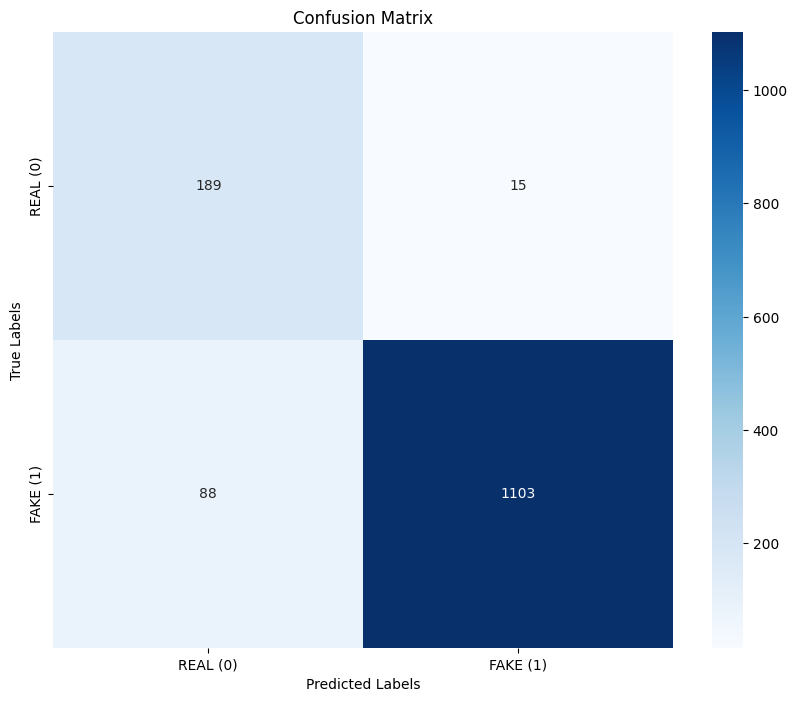

2025-06-09 13:27:12,970: INFO: 
--- Ringkasan Evaluasi Akhir (dari Checkpoint) ---
2025-06-09 13:27:12,971: INFO:   Loss Validasi Rata-rata: 0.2230
2025-06-09 13:27:12,971: INFO:   Akurasi Validasi: 92.62%
2025-06-09 13:27:12,971: INFO: --- Sesi Pengujian Model Selesai ---


In [34]:
# SEL SETELAH PELATIHAN SELESAI
# Pastikan semua definisi model, dataset, config, AGDA, AverageMeter, ACC sudah ada.
# Dan variabel 'net' (model yang sudah dilatih), 'validate_loader', 'device',
# dan 'config_global' sudah tersedia dari proses training.

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan fungsi ACC dan AverageMeter sudah didefinisikan seperti sebelumnya
# class AverageMeter: ...
# def ACC(logit, target): ...

def evaluate_and_plot_confusion_matrix(model, data_loader, device, num_classes, class_names=None):
    """
    Mengevaluasi model pada data_loader yang diberikan, menghitung,
    dan memplot confusion matrix.

    Args:
        model (nn.Module): Model PyTorch yang akan dievaluasi.
        data_loader (DataLoader): DataLoader untuk set data evaluasi.
        device (torch.device): Device untuk komputasi (cpu atau cuda).
        num_classes (int): Jumlah total kelas.
        class_names (list, optional): Daftar nama kelas untuk label plot.
                                      Jika None, akan menggunakan angka 0, 1, ...
    """
    model.eval()  # Set model ke mode evaluasi
    all_preds = []
    all_labels = []
    total_loss = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss() # Untuk menghitung loss jika diperlukan

    logging.info(f"Memulai evaluasi untuk confusion matrix pada {len(data_loader.dataset)} sampel...")

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Dapatkan output logits dari model
            # Asumsi forward pass untuk evaluasi tidak memerlukan argumen y atau train_batch_flag,
            # atau jika memerlukan, MAT.forward akan menanganinya dengan benar saat eval.
            # MAT.forward saat train_batch_flag=False akan mengembalikan logits.
            outputs = model(inputs, train_batch_flag=False) # y tidak diperlukan saat eval

            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i + 1) % 50 == 0 or i == len(data_loader) - 1:
                logging.info(f"Evaluasi batch [{i+1}/{len(data_loader)}]")

    avg_loss = total_loss / total_samples
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels) * 100

    logging.info(f"Evaluasi Selesai. Loss Rata-rata: {avg_loss:.4f}, Akurasi: {accuracy:.2f}%")

    # Buat Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    # Cetak Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0)
    print("\nClassification Report:\n", report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm, report, accuracy, avg_loss

# --- Cara Menggunakan Setelah Loop Pelatihan ---
# Asumsikan loop pelatihan Anda sudah selesai dan Anda memiliki:
# - net: model MAT yang sudah dilatih (misalnya, dari checkpoint terbaik atau epoch terakhir)
# - validate_loader: DataLoader untuk data validasi
# - device: device yang digunakan
# - config_global: objek konfigurasi Anda

# ... (Fungsi evaluate_and_plot_confusion_matrix dan impor tetap sama) ...

if __name__ == '__main__' or '__file__' not in globals(): # Agar bisa dijalankan di notebook
    logging.info("--- Memulai Sesi Pengujian Model ---")

    # 1. Dapatkan Konfigurasi
    # Pastikan kelas Config sudah didefinisikan di sel sebelumnya atau di sel ini.
    if 'config_global' not in globals() or config_global is None:
        logging.info("Objek 'config_global' tidak ditemukan atau None. Membuat instance baru...")
        config_global = Config()
    else:
        logging.info("Menggunakan 'config_global' yang sudah ada.")

    # Pastikan device juga sudah terdefinisi
    if 'device' not in globals() or device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logging.info(f"Device diinisialisasi ulang ke: {device}")


    # 2. Inisialisasi Model Baru untuk Evaluasi
    # Selalu inisialisasi model baru untuk memastikan tidak ada state sisa dari training.
    logging.info(f"Menginisialisasi model MAT baru untuk evaluasi dengan backbone: {config_global.net_config['net']}")
    try:
        net_eval = MAT(**config_global.net_config).to(device)
    except Exception as e_init:
        logging.error(f"Error saat menginisialisasi model MAT untuk evaluasi: {e_init}")
        import traceback
        traceback.print_exc()
        net_eval = None # Set ke None jika gagal

    if net_eval is not None:
        # 3. Tentukan Path Checkpoint yang Akan Dimuat
        # Anda bisa memilih antara checkpoint terbaik atau epoch terakhir.
        # Untuk contoh ini, kita coba muat epoch terakhir yang disimpan.
        # Asumsi config_global.epochs adalah jumlah TOTAL epoch yang dijalankan (misal 3, jadi epoch terakhir adalah 2)
        last_epoch_trained = config_global.epochs - 1
        checkpoint_to_load_path = os.path.join('checkpoints', config_global.name, f'ckpt_{last_epoch_trained}.pth')
        
        # Atau jika Anda ingin memuat yang terbaik:
        # checkpoint_to_load_path = os.path.join('checkpoints', config_global.name, 'ckpt_best_acc.pth')

        logging.info(f"Mencoba memuat checkpoint dari: {checkpoint_to_load_path}")

        if os.path.exists(checkpoint_to_load_path):
            try:
                checkpoint = torch.load(checkpoint_to_load_path, map_location=device)
                state_dict_to_load = checkpoint.get('state_dict', checkpoint) # Handle jika ckpt adalah dict atau state_dict langsung

                if load_state(net_eval, state_dict_to_load):
                    logging.info(f"Bobot model berhasil dimuat dari {checkpoint_to_load_path}.")
                    # Jika ada info akurasi di checkpoint (misalnya dari ckpt_best_acc), bisa ditampilkan
                    ckpt_logs = checkpoint.get('logs', {})
                    val_acc_from_ckpt = ckpt_logs.get('valid_ensemble_acc', ckpt_logs.get('valid_acc', 'N/A'))
                    if val_acc_from_ckpt != 'N/A':
                        logging.info(f"Info dari checkpoint: Akurasi Validasi = {val_acc_from_ckpt:.2f}% (pada epoch {ckpt_logs.get('epoch', '?')})")
                else:
                    logging.warning(f"Gagal memuat state_dict secara penuh dari {checkpoint_to_load_path}. Model mungkin tidak berperforma baik.")
                    net_eval = None # Anggap gagal jika load_state tidak berhasil penuh
            except Exception as e_load:
                logging.error(f"Error saat memuat checkpoint {checkpoint_to_load_path}: {e_load}")
                import traceback
                traceback.print_exc()
                net_eval = None
        else:
            logging.warning(f"File checkpoint tidak ditemukan di {checkpoint_to_load_path}. Tidak dapat mengevaluasi model terlatih.")
            net_eval = None
    
    # 4. Siapkan DataLoader untuk Validasi
    validate_loader_eval = None
    if net_eval is not None: # Hanya buat loader jika model berhasil dimuat
        # Pastikan DeepfakeDataset sudah didefinisikan
        if 'DeepfakeDataset' not in globals():
            logging.error("Kelas DeepfakeDataset tidak terdefinisi. Tidak bisa membuat data loader.")
        else:
            logging.info("Membuat DataLoader validasi untuk evaluasi...")
            try:
                validate_dataset_eval = DeepfakeDataset(phase='test', **config_global.val_dataset)
                if len(validate_dataset_eval) > 0:
                    validate_loader_eval = DataLoader(validate_dataset_eval,
                                                  batch_size=config_global.batch_size, # Gunakan batch_size dari config
                                                  shuffle=False,
                                                  pin_memory=True,
                                                  num_workers=config_global.workers)
                    logging.info("DataLoader validasi berhasil dibuat.")
                else:
                    logging.warning("Dataset validasi kosong, tidak bisa membuat DataLoader.")
            except Exception as e_dl:
                logging.error(f"Error saat membuat DataLoader validasi: {e_dl}")
                import traceback
                traceback.print_exc()

    # 5. Lakukan Evaluasi dan Plot Confusion Matrix
    if net_eval is not None and validate_loader_eval is not None:
        logging.info("Memulai evaluasi akhir dan plotting confusion matrix...")
        num_classes_eval = config_global.net_config['num_classes']
        class_names_eval = [f"Class {i}" for i in range(num_classes_eval)]
        if num_classes_eval == 2:
            # Sesuaikan ini dengan pemetaan label Anda: 0->REAL, 1->FAKE atau sebaliknya
            class_names_eval = ['REAL (0)', 'FAKE (1)']

        try:
            cm_result, report_result, acc_result, loss_result = evaluate_and_plot_confusion_matrix(
                model=net_eval,
                data_loader=validate_loader_eval,
                device=device,
                num_classes=num_classes_eval,
                class_names=class_names_eval
            )
            logging.info(f"\n--- Ringkasan Evaluasi Akhir (dari Checkpoint) ---")
            logging.info(f"  Loss Validasi Rata-rata: {loss_result:.4f}")
            logging.info(f"  Akurasi Validasi: {acc_result:.2f}%")
            # cm_result adalah numpy array dari confusion matrix
        except Exception as e_eval:
            logging.error(f"Error saat evaluasi dan plotting confusion matrix: {e_eval}")
            import traceback
            traceback.print_exc()
    else:
        logging.warning("Tidak bisa melakukan evaluasi karena model atau data loader validasi tidak tersedia/gagal dimuat.")

    logging.info("--- Sesi Pengujian Model Selesai ---")

# Save Model

In [36]:
import os
config_name_check = "ffpp_mat_effnetb0_notebook_v2" # Sesuaikan dengan config.name Anda
checkpoint_dir_check = os.path.join('checkpoints', config_name_check)
print(f"Mengecek direktori: {checkpoint_dir_check}")
if os.path.exists(checkpoint_dir_check):
    print(f"Isi direktori '{checkpoint_dir_check}':")
    print(os.listdir(checkpoint_dir_check))
else:
    print(f"Direktori '{checkpoint_dir_check}' TIDAK DITEMUKAN.")

Mengecek direktori: checkpoints/ffpp_mat_effnetb0_notebook_v2
Isi direktori 'checkpoints/ffpp_mat_effnetb0_notebook_v2':
['ckpt_9.pth', 'ckpt_8.pth', 'ckpt_4.pth', 'ckpt_0.pth', 'ckpt_6.pth', 'ckpt_3.pth', 'ckpt_2.pth', 'ckpt_7.pth', 'ckpt_5.pth', 'ckpt_1.pth']


In [38]:
# SEL 2: MENYIMPAN MODEL FINAL UNTUK INFERENSI
# Jalankan sel ini SETELAH sel training selesai.

import os
import torch
import logging # Pastikan logging sudah di-import dan dikonfigurasi

# Asumsikan 'config_global' dan 'device' masih ada dari sel training.
# Jika tidak, Anda perlu mendefinisikannya lagi atau memuatnya.
if 'config_global' not in globals() or config_global is None:
    logging.warning("Objek 'config_global' tidak ditemukan. Membuat instance baru untuk path penyimpanan.")
    # Anda perlu kelas Config didefinisikan jika ingin membuat instance baru
    # class Config: ... (definisi dari sel training)
    config_global = Config() # Ini akan menggunakan nilai default Config

if 'device' not in globals() or device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Device diinisialisasi ulang ke: {device}")


# Tentukan path checkpoint mana yang ingin Anda simpan sebagai model final
# Misalnya, model terbaik
final_model_source_path = os.path.join('checkpoints', config_global.name, 'ckpt_9.pth')
# Atau epoch terakhir
# final_model_source_path = os.path.join('checkpoints', config_global.name, f'ckpt_{config_global.epochs-1}.pth')

final_model_save_path = os.path.join('models_final', f"{config_global.name}_final_model.pth")
os.makedirs(os.path.dirname(final_model_save_path), exist_ok=True)

if os.path.exists(final_model_source_path):
    logging.info(f"Mencoba memuat checkpoint dari: {final_model_source_path} untuk disimpan sebagai model final.")
    try:
        checkpoint = torch.load(final_model_source_path, map_location=device)
        model_state_dict = checkpoint.get('state_dict')

        if model_state_dict:
            # Hanya simpan state_dict modelnya saja
            torch.save(model_state_dict, final_model_save_path)
            logging.info(f"Model final (hanya state_dict) berhasil disimpan ke: {final_model_save_path}")
        else:
            logging.error(f"'state_dict' tidak ditemukan dalam checkpoint: {final_model_source_path}")

    except Exception as e:
        logging.error(f"Error saat memproses checkpoint untuk penyimpanan final: {e}")
        import traceback
        traceback.print_exc()
else:
    logging.warning(f"File checkpoint sumber '{final_model_source_path}' tidak ditemukan. Tidak ada model final yang disimpan.")

2025-06-09 13:33:07,013: INFO: Mencoba memuat checkpoint dari: checkpoints/ffpp_mat_effnetb0_notebook_v2/ckpt_9.pth untuk disimpan sebagai model final.
2025-06-09 13:33:07,321: INFO: Model final (hanya state_dict) berhasil disimpan ke: models_final/ffpp_mat_effnetb0_notebook_v2_final_model.pth


## Inference Mode

In [42]:
# SEL UNTUK INFERENSI MODEL YANG DISIMPAN

import os
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import logging
import matplotlib.pyplot as plt # Opsional, untuk menampilkan gambar

# --- Pengaturan Awal ---
# Pastikan logging dikonfigurasi jika belum
if not logging.getLogger().hasHandlers():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s: %(levelname)s: %(message)s', force=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Inferensi akan menggunakan device: {device}")

# =============================================================================
# PENTING: SALIN SEMUA DEFINISI KELAS MODEL DARI NOTEBOOK TRAINING KE SINI
# Ini termasuk:
# 1. Kelas Config (sama persis seperti saat training)
# 2. Semua kelas backbone (EfficientNet, xception_model, dan komponennya)
# 3. Semua kelas MAT (MAT, AttentionMap, AttentionPooling, TextureEnhance, AuxLoss)
# 4. Fungsi load_state
# =============================================================================

# --- CONTOH MINIMAL DEFINISI YANG MUNGKIN ANDA PERLUKAN JIKA BELUM ADA ---
# --- ANDA HARUS MEMILIKI DEFINISI LENGKAP DAN BENAR DARI MODEL ANDA ---

# class Config: # <<< GANTI DENGAN DEFINISI Config LENGKAP ANDA
#     def __init__(self):
#         self.name = "ffpp_mat_effnetb0_notebook_v2" # Harus sesuai dengan path model
#         # Parameter net_config HARUS SAMA PERSIS seperti saat training model yang disimpan
#         self.net_config = {
#             'net': 'efficientnet-b0',
#             'feature_layer': 'b3',
#             'attention_layer': 'b5',
#             'num_classes': 2, # Sesuaikan jika berbeda
#             'M': 4,           # Sesuaikan jika berbeda
#             'mid_dims': 128,  # Sesuaikan jika berbeda
#             'dropout_rate': 0.3, # Tidak terlalu penting untuk inferensi jika model.eval()
#             'drop_final_rate': 0.3, # Tidak terlalu penting untuk inferensi
#             'pretrained_backbone': False, # Set False karena kita memuat bobot MAT yang sudah termasuk backbone
#             'pretrained_mat': None,
#             'alpha': 0.05, # Tidak penting untuk inferensi
#             'size': (224, 224), # Ukuran input yang diharapkan model
#             'margin': 1.0,      # Tidak penting untuk inferensi
#             'inner_margin': [0.01, 0.02], # Tidak penting untuk inferensi
#             'aux_loss_ver': 1, # Tidak penting untuk inferensi
#             'texture_enhance_ver': 2 # Harus sama dengan saat training
#         }
# # --- AKHIR CONTOH MINIMAL ---

# Pastikan semua kelas model (EfficientNet, MAT, dll.) dan fungsi load_state
# sudah didefinisikan di atas sel ini atau di sel sebelumnya.
# Misal:
# class EfficientNet(nn.Module): ...
# class MAT(nn.Module): ...
# def load_state(net, ckpt_state_dict): ...


def preprocess_image_for_inference(image_path, image_size=(224, 224)):
    """
    Memuat dan melakukan preprocessing pada satu gambar untuk inferensi.
    Normalisasi HARUS SAMA dengan yang digunakan saat training.
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(image_size) # Simpan gambar asli untuk display jika perlu
        img_np = np.array(img_resized, dtype=np.float32) / 255.0
        # Normalisasi ImageNet (umum untuk EfficientNet/Xception)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np_normalized = (img_np - mean) / std
        img_tensor = torch.from_numpy(img_np_normalized.transpose(2, 0, 1)).float() # CHW
        return img_tensor.unsqueeze(0), img # Kembalikan juga gambar PIL asli untuk display
    except FileNotFoundError:
        logging.error(f"Gambar tidak ditemukan di: {image_path}")
        return None, None
    except Exception as e_prep:
        logging.error(f"Error saat preprocessing gambar {image_path}: {e_prep}")
        return None, None

def predict_single_image(model, image_tensor, device, class_names_map):
    """
    Melakukan prediksi pada satu tensor gambar.
    """
    model.eval() # Pastikan model dalam mode evaluasi
    if image_tensor is None:
        return "Preprocessing Gagal", None, None

    input_tensor_on_device = image_tensor.to(device)
    with torch.no_grad():
        # MAT.forward untuk inferensi: model(input, train_batch_flag=False)
        output_logits = model(input_tensor_on_device, train_batch_flag=False)
        probabilities = F.softmax(output_logits, dim=1)
        confidence, predicted_idx_tensor = torch.max(probabilities, 1)

        predicted_idx = predicted_idx_tensor.item()
        predicted_class_name = class_names_map.get(predicted_idx, f"Unknown Class ({predicted_idx})")
        confidence_score = confidence.item()

    return predicted_class_name, confidence_score, probabilities.cpu().numpy().flatten()

# --- Langkah-langkah Utama untuk Inferensi ---

# 1. Buat instance konfigurasi (HARUS SAMA dengan saat training)
# Jika kelas Config belum didefinisikan di notebook ini, Anda akan mendapatkan NameError.
# Pastikan sel yang mendefinisikan Config (dan semua model) sudah dijalankan.
try:
    config_for_inference = Config()
except NameError:
    logging.error("Kelas 'Config' belum terdefinisi. Harap definisikan kelas Config "
                  "dan semua kelas model yang diperlukan di sel sebelumnya atau di atas kode ini.")
    raise # Hentikan eksekusi jika Config tidak ada

# 2. Inisialisasi arsitektur model
# net_config dari config_for_inference harus sama dengan yang digunakan untuk melatih model yang disimpan.
logging.info(f"Menginisialisasi arsitektur model MAT: {config_for_inference.net_config['net']}")
try:
    # Untuk inferensi dari state_dict yang sudah lengkap (termasuk backbone),
    # biasanya pretrained_backbone=False saat inisialisasi MAT.
    inference_model_config = config_for_inference.net_config.copy()
    inference_model_config['pretrained_backbone'] = False # Asumsi state_dict yang disimpan sudah lengkap

    loaded_model = MAT(**inference_model_config).to(device)
except NameError as ne:
    logging.error(f"Error: Kelas model (MAT atau backbone seperti EfficientNet/xception_model) belum terdefinisi: {ne}. "
                  "Pastikan semua definisi kelas model ada di sel sebelumnya.")
    loaded_model = None
except Exception as e_init_inf:
    logging.error(f"Error saat menginisialisasi model MAT untuk inferensi: {e_init_inf}")
    import traceback
    traceback.print_exc()
    loaded_model = None


if loaded_model is not None:
    # 3. Tentukan path ke model yang disimpan
    model_path = "/kaggle/working/models_final/ffpp_mat_effnetb0_notebook_v2_final_model.pth" # Path yang Anda berikan
    logging.info(f"Mencoba memuat bobot model dari: {model_path}")

    if os.path.exists(model_path):
        try:
            # Muat state_dict. File ini HARUS hanya berisi state_dict.
            state_dict_to_load = torch.load(model_path, map_location=device)
            
            # Pastikan fungsi load_state sudah didefinisikan
            if 'load_state' not in globals():
                logging.error("Fungsi 'load_state' tidak terdefinisi.")
                raise NameError("Fungsi load_state tidak ada. Harap definisikan.")

            if load_state(loaded_model, state_dict_to_load): # Menggunakan fungsi load_state Anda
                logging.info("Bobot model berhasil dimuat untuk inferensi.")
                loaded_model.eval() # PENTING: Set model ke mode evaluasi

                # 4. Siapkan path gambar sampel untuk inferensi
                # GANTI DENGAN PATH GAMBAR ANDA
                # Contoh path dari dataset FF++:
                sample_image_paths = [
                    "/kaggle/input/ffpp-fix/frames_cropped_new/original_123_0000.jpg", # Contoh Real
                    "/kaggle/input/ffpp-fix/frames_cropped_new/DeepFakeDetection_01_02__outside_talking_still_laughing__YVGY8LOK_0000.jpg", # Contoh Fake
                    "/kaggle/input/ffpp-fix/frames_cropped_new/DeepFakeDetection_03_06__exit_phone_room__1IXGY2FK_0000.jpg", # Contoh lain
                    # Tambahkan path gambar lain yang ingin Anda uji
                ]
                # Jika Anda tidak memiliki path tersebut, ganti dengan path gambar yang valid di environment Anda.
                # Atau, jika path di atas tidak ada, kode akan error saat preprocessing.
                # Untuk pengujian, Anda bisa mengunggah beberapa gambar ke environment notebook.

                # Definisikan nama kelas (sesuaikan dengan output model Anda)
                num_classes_model = config_for_inference.net_config['num_classes']
                if num_classes_model == 2:
                    class_names_map_inference = {0: "REAL", 1: "FAKE"} # Asumsi 0:Real, 1:Fake
                else:
                    class_names_map_inference = {i: f"Kelas {i}" for i in range(num_classes_model)}

                # 5. Lakukan Inferensi pada setiap gambar sampel
                for img_path_to_test in sample_image_paths:
                    if not os.path.exists(img_path_to_test):
                        logging.warning(f"File gambar sampel tidak ditemukan: {img_path_to_test}. Melewati.")
                        continue

                    logging.info(f"\nMelakukan prediksi untuk: {os.path.basename(img_path_to_test)}")
                    input_tensor, original_pil_image = preprocess_image_for_inference(
                        img_path_to_test,
                        image_size=config_for_inference.net_config['size']
                    )

                    if input_tensor is not None:
                        predicted_class, confidence, all_probs = predict_single_image(
                            loaded_model, input_tensor, device, class_names_map_inference
                        )
                        logging.info(f"  >> Prediksi: {predicted_class}")
                        logging.info(f"  >> Skor Kepercayaan: {confidence:.4f}")
                        logging.info(f"  >> Probabilitas Semua Kelas: {all_probs}")

                        # Opsional: Tampilkan gambar dan prediksi
                        # if original_pil_image is not None and 'matplotlib' in sys.modules:
                        #     plt.imshow(original_pil_image)
                        #     plt.title(f"Prediksi: {predicted_class} ({confidence:.2f})")
                        #     plt.axis('off')
                        #     plt.show()
                    else:
                        logging.warning(f"Preprocessing gagal untuk gambar: {img_path_to_test}")
            else:
                logging.error("Gagal memuat state_dict ke model inferensi secara penuh.")
        except FileNotFoundError:
            logging.error(f"File model yang disimpan tidak ditemukan di: {model_path}")
        except Exception as e_load_inf_final:
            logging.error(f"Error umum saat memuat model atau melakukan inferensi: {e_load_inf_final}")
            import traceback
            traceback.print_exc()
    else:
        logging.warning(f"File model yang disimpan tidak ada, atau model gagal diinisialisasi. Tidak dapat melakukan inferensi: {model_path if loaded_model else 'Model Gagal Inisialisasi'}")
else:
    logging.warning("Model untuk inferensi tidak berhasil diinisialisasi (kemungkinan kelas model tidak terdefinisi).")

logging.info("--- Sesi Inferensi Selesai ---")

2025-06-09 13:38:58,737: INFO: Inferensi akan menggunakan device: cuda
2025-06-09 13:38:58,740: INFO: Menginisialisasi arsitektur model MAT: efficientnet-b0
2025-06-09 13:38:58,740: INFO: MAT: Menginisialisasi backbone 'efficientnet-b0'...
2025-06-09 13:38:58,785: INFO: MAT: Dry run backbone dengan input size (224, 224)...
2025-06-09 13:38:58,831: INFO: MAT: Dimensi fitur - Dari backbone (b3): 40
2025-06-09 13:38:58,832: INFO: MAT: Dimensi input AttentionMap (b5): 112
2025-06-09 13:38:58,832: INFO: MAT: Dimensi input cabang global (final): 1280
2025-06-09 13:38:58,835: INFO: MAT: Menggunakan TextureEnhance v2
2025-06-09 13:38:58,843: INFO: MAT: Menggunakan AuxiliaryLoss v1
2025-06-09 13:38:58,862: INFO: Mencoba memuat bobot model dari: /kaggle/working/models_final/ffpp_mat_effnetb0_notebook_v2_final_model.pth
2025-06-09 13:38:58,965: INFO: Berhasil memuat 434 kunci. Kunci hilang di model: []. Kunci tak terduga di checkpoint: []
2025-06-09 13:38:58,966: INFO: Bobot model berhasil dimuat

# Show sample

2025-06-09 12:47:18,440: INFO: Dataset phase: train, augment: True, number of samples: 5579
2025-06-09 12:47:18,466: INFO: Dataset phase: test, augment: False, number of samples: 1395


Membuat dataset untuk menampilkan sampel...

--- Menampilkan Sampel dari Data Training ---


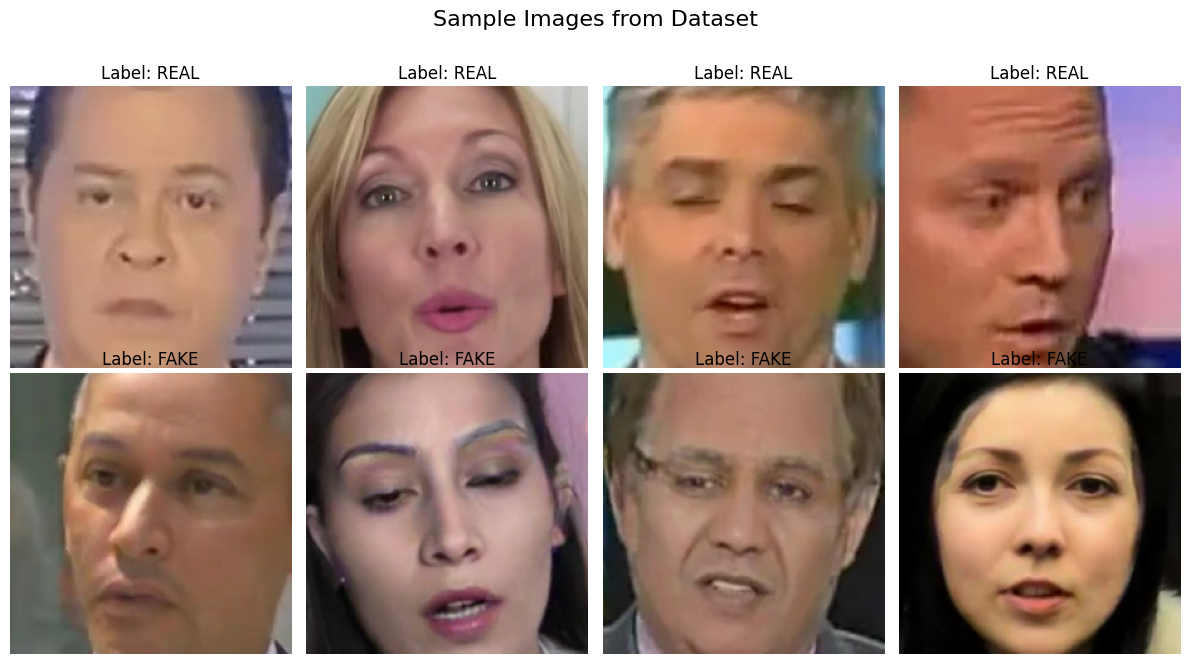


--- Menampilkan Sampel dari Data Validasi ---


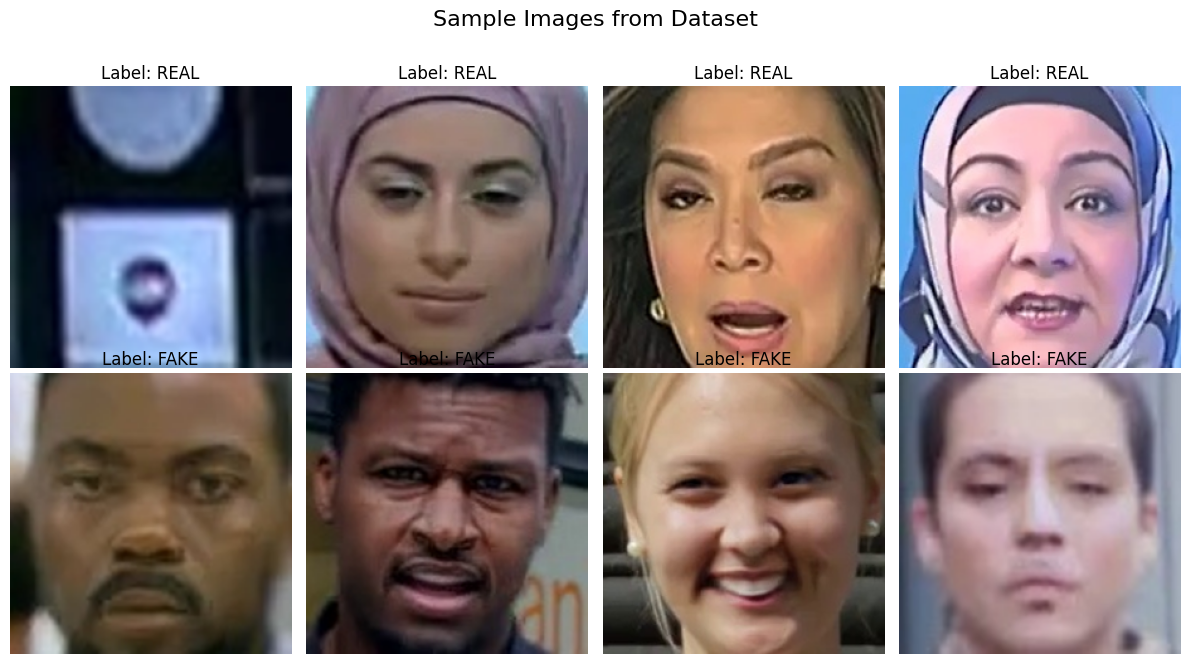

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Asumsikan kelas DeepfakeDataset dan Config sudah didefinisikan seperti sebelumnya
# dan variabel config_global sudah ada.

def display_sample_images(dataset, num_samples_per_class=5, class_names=None, image_size=(224,224)):
    """
    Menampilkan sampel gambar original dan fake dari dataset.

    Args:
        dataset (Dataset): Objek Dataset PyTorch (misalnya, DeepfakeDataset).
        num_samples_per_class (int): Jumlah sampel yang akan ditampilkan per kelas.
        class_names (dict, optional): Dictionary mapping label ke nama kelas, cth: {0: 'REAL', 1: 'FAKE'}.
                                      Jika None, akan menggunakan "Class 0", "Class 1".
        image_size (tuple): Ukuran gambar yang diharapkan untuk display jika gambar perlu di-resize.
    """
    if class_names is None:
        # Coba dapatkan jumlah kelas dari dataset jika mungkin, atau asumsikan 2
        try:
            # Ini asumsi, mungkin perlu cara lain untuk dapatkan num_classes dari dataset Anda
            labels_set = set()
            if hasattr(dataset, 'current_df') and 'label' in dataset.current_df.columns:
                 labels_set = set(dataset.current_df['label'].unique())
            elif hasattr(dataset, 'df') and 'label' in dataset.df.columns: # fallback jika current_df tidak ada
                 labels_set = set(dataset.df['label'].unique())

            if labels_set:
                num_classes_ds = len(labels_set)
                class_names = {i: f"Class {i}" for i in range(num_classes_ds)}
                if num_classes_ds == 2 and (0 in labels_set and 1 in labels_set): # Asumsi umum 0 dan 1
                    class_names = {0: 'REAL (Label 0)', 1: 'FAKE (Label 1)'} # Sesuaikan jika label berbeda
            else: # Default jika tidak bisa mendapatkan info kelas
                class_names = {0: 'REAL (Label 0)', 1: 'FAKE (Label 1)'}
        except:
            class_names = {0: 'REAL (Label 0)', 1: 'FAKE (Label 1)'} # Fallback

    # Kumpulkan indeks untuk setiap kelas
    indices_per_class = {label: [] for label in class_names.keys()}
    if hasattr(dataset, 'current_df') and 'label' in dataset.current_df.columns:
        for i in range(len(dataset)):
            label = dataset.current_df.iloc[i]['label']
            if label in indices_per_class:
                indices_per_class[label].append(i)
    elif hasattr(dataset, 'df') and 'label' in dataset.df.columns: # fallback
         for i in range(len(dataset)):
            label = dataset.df.iloc[i]['label']
            if label in indices_per_class:
                indices_per_class[label].append(i)
    else:
        logging.warning("Tidak dapat mengakses data label dari dataset untuk sampling. Menampilkan sampel acak.")
        # Jika tidak bisa akses label, tampilkan sampel acak saja
        if len(dataset) < num_samples_per_class * len(class_names):
            print(f"Dataset terlalu kecil ({len(dataset)} sampel) untuk menampilkan {num_samples_per_class} sampel per {len(class_names)} kelas.")
            return

        fig, axes = plt.subplots(1, num_samples_per_class, figsize=(15, 5))
        if num_samples_per_class == 1: axes = [axes] # Buat bisa diiterasi
        fig.suptitle(f"Random Samples from Dataset", fontsize=16)
        for i in range(num_samples_per_class):
            idx = random.randint(0, len(dataset) - 1)
            img_tensor, _ = dataset[idx] # Abaikan label karena kita tidak tahu

            # Konversi tensor ke format gambar yang bisa ditampilkan
            if isinstance(img_tensor, torch.Tensor):
                # Denormalize jika perlu (asumsi normalisasi ImageNet)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = img_tensor.cpu().numpy().transpose((1, 2, 0)) # CHW to HWC
                img_np = std * img_np + mean # Denormalize
                img_np = np.clip(img_np, 0, 1) # Pastikan nilai dalam rentang [0,1]
                axes[i].imshow(img_np)
            elif isinstance(img_tensor, Image.Image): # Jika dataset mengembalikan PIL Image
                axes[i].imshow(img_tensor)
            else:
                axes[i].text(0.5, 0.5, 'Cannot display image', ha='center', va='center')

            axes[i].set_title(f"Random Sample {i+1}")
            axes[i].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        return


    # Pastikan ada cukup sampel untuk setiap kelas
    for label, indices in indices_per_class.items():
        if len(indices) < num_samples_per_class:
            print(f"Peringatan: Kelas '{class_names.get(label, f'Label {label}')}' hanya memiliki {len(indices)} sampel, "
                  f"kurang dari {num_samples_per_class} yang diminta.")

    # Tentukan jumlah baris dan kolom untuk plot
    num_classes_to_plot = len(class_names)
    fig, axes = plt.subplots(num_classes_to_plot, num_samples_per_class,
                             figsize=(3 * num_samples_per_class, 3 * num_classes_to_plot + 1))
    if num_classes_to_plot == 1: axes = np.array([axes]) # Buat bisa diindeks 2D
    if num_samples_per_class == 1: axes = axes.reshape(-1,1) # Buat bisa diindeks 2D

    fig.suptitle("Sample Images from Dataset", fontsize=16)

    for i, (label_val, class_name) in enumerate(class_names.items()):
        sample_indices = indices_per_class.get(label_val, [])
        if not sample_indices:
            # Jika tidak ada sampel untuk kelas ini, tampilkan placeholder
            for j in range(num_samples_per_class):
                ax = axes[i, j] if num_classes_to_plot > 1 else axes[j]
                ax.text(0.5, 0.5, f"No samples for\n'{class_name}'", ha='center', va='center')
                ax.axis('off')
            continue

        # Ambil sampel acak dari indeks yang tersedia untuk kelas ini
        display_indices = random.sample(sample_indices, min(num_samples_per_class, len(sample_indices)))

        for j, idx in enumerate(display_indices):
            img_tensor, true_label = dataset[idx] # true_label adalah tensor

            ax = axes[i, j] if num_classes_to_plot > 1 else axes[j]

            # Konversi tensor ke format gambar yang bisa ditampilkan
            if isinstance(img_tensor, torch.Tensor):
                # Denormalize jika perlu (asumsi normalisasi ImageNet)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = img_tensor.cpu().numpy().transpose((1, 2, 0)) # CHW to HWC
                img_np = std * img_np + mean # Denormalize
                img_np = np.clip(img_np, 0, 1) # Pastikan nilai dalam rentang [0,1]
                ax.imshow(img_np)
            elif isinstance(img_tensor, Image.Image): # Jika dataset mengembalikan PIL Image
                ax.imshow(img_tensor)
            else:
                ax.text(0.5, 0.5, 'Cannot display image', ha='center', va='center')
                # print(f"Tipe gambar tidak didukung untuk display: {type(img_tensor)}")


            if j == 0: # Hanya setel judul Y untuk kolom pertama
                ax.set_ylabel(class_name, fontsize=12, rotation=0, labelpad=40, verticalalignment='center')
            ax.set_title(f"Label: {class_names.get(true_label.item(), true_label.item())}")
            ax.axis('off')
        
        # Jika sampel yang ditampilkan lebih sedikit dari num_samples_per_class, isi sisanya
        for j_empty in range(len(display_indices), num_samples_per_class):
            ax = axes[i, j_empty] if num_classes_to_plot > 1 else axes[j_empty]
            ax.axis('off') # Kosongkan subplot


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Sesuaikan rect untuk suptitle
    plt.show()


# --- Cara Menggunakan ---
# Asumsikan Anda sudah memiliki 'config_global' dan 'DeepfakeDataset' didefinisikan.
# Dan sel yang berisi definisi model dan kode train sudah dijalankan.

if __name__ == '__main__' or '__file__' not in globals():
    # Buat instance dataset (misalnya, dari data training atau validasi)
    # Untuk contoh ini, kita buat dataset training baru
    if 'config_global' not in globals():
        print("Objek 'config_global' tidak ditemukan. Membuat instance baru...")
        config_global = Config() # Pastikan kelas Config sudah didefinisikan

    print("Membuat dataset untuk menampilkan sampel...")
    try:
        # Anda bisa menggunakan train_dataset atau validate_dataset yang sudah ada
        # jika sudah diinisialisasi di scope global saat training.
        # Atau buat instance baru:
        sample_dataset_train = DeepfakeDataset(phase='train', **config_global.train_dataset)
        sample_dataset_val = DeepfakeDataset(phase='test', **config_global.val_dataset)
        
        # Definisikan nama kelas sesuai dengan label Anda
        # Misal, jika 0 adalah REAL dan 1 adalah FAKE
        class_mapping = {0: 'REAL', 1: 'FAKE'}
        # Jika label Anda berbeda (misalnya, 1 untuk REAL, 0 untuk FAKE), sesuaikan mapping ini.
        # Atau jika lebih dari 2 kelas.

        if len(sample_dataset_train) > 0:
            print("\n--- Menampilkan Sampel dari Data Training ---")
            display_sample_images(sample_dataset_train, num_samples_per_class=4, class_names=class_mapping)
        else:
            print("Dataset training kosong, tidak bisa menampilkan sampel.")

        if len(sample_dataset_val) > 0:
            print("\n--- Menampilkan Sampel dari Data Validasi ---")
            display_sample_images(sample_dataset_val, num_samples_per_class=4, class_names=class_mapping)
        else:
            print("Dataset validasi kosong, tidak bisa menampilkan sampel.")

    except Exception as e_display:
        print(f"Error saat mencoba menampilkan sampel gambar: {e_display}")
        import traceback
        traceback.print_exc()